In [1]:
import pandas as pd
import numpy as np
#pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import dython
from dython.nominal import associations
import chart_studio.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True) 
from scipy import stats
from sklearn.model_selection import train_test_split
from feature_engine.encoding import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings("ignore")

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# read in the cleaned MH dataset

df = pd.read_csv("cleaned_MH_dataset.csv", index_col=0)
df

,Year,What is your age?,What is your gender?,What country do you live in?,What US state or territory do you live in?,Do you have a family history of mental illness?,Do you currently have a mental health disorder?,Have you ever sought treatment for a mental health issue from a mental health professional?,Do you believe your productivity is ever affected by a mental health issue?,Are you self-employed?,...,"If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?",Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided coverage?,Does your employer offer resources to learn more about mental health concerns and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Would you bring up a mental health issue with a potential employer in an interview?,Why or why not?,Would you feel comfortable discussing a mental health disorder with your coworkers?,Describe the conversation with coworkers you had about your mental health including their reactions.
0,2014,37.0,female,United States,IL,No,NaN,Yes,Yes,NaN,...,Easy,Yes,Not sure,Yes,Yes,No,No,NaN,Yes,NaN
1,2014,44.0,male,United States,IN,No,NaN,No,No,NaN,...,Don't know,Don't know,No,Don't know,Don't know,Don't know,No,NaN,No,NaN
2,2014,32.0,male,Canada,NaN,No,NaN,No,No,NaN,...,Difficult,No,No,No,Don't know,No,Yes,NaN,Yes,NaN
3,2014,31.0,male,United Kingdom,NaN,Yes,NaN,Yes,Yes,NaN,...,Difficult,No,Yes,No,No,No,Maybe,NaN,Yes,NaN
4,2014,31.0,male,United States,TX,No,NaN,No,No,NaN,...,Don't know,Yes,No,Don't know,Don't know,Don't know,Yes,NaN,Yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,2020,53.0,male,United States of America,NY,No,No,No,NaN,No,...,Difficult,No,No,No,No,No,No,No new employer would care about our issues. T...,No,NaN
4394,2020,23.0,female,Philippines,NaN,No,Yes,No,NaN,No,...,Easy,Yes,Yes,Yes,Don't know,Yes,Maybe,NaN,Maybe,NaN
4395,2020,34.0,male,United States of America,TN,Yes,Yes,Yes,NaN,No,...,Easy,Don't know,No,Don't know,Don't know,No,No,I don't wish to discuss physical health issues...,Maybe,It was other people who also had issues too so...
4396,2020,43.0,male,Canada,NaN,Yes,Yes,Yes,NaN,No,...,Difficult,Yes,No,Yes,Yes,Yes,No,uncomfortable. if I felt that my health was g...,Maybe,NaN


In [4]:
# Basic summary of the dataset

print(df.shape) 
print(df.size) 
print(df.info()) 

(4398, 23)
101154
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4398 entries, 0 to 4397
Data columns (total 23 columns):
 #   Column                                                                                                                                          Non-Null Count  Dtype  
---  ------                                                                                                                                          --------------  -----  
 0   Year                                                                                                                                            4398 non-null   int64  
 1   What is your age?                                                                                                                               4396 non-null   float64
 2   What is your gender?                                                                                                                            4398 non-null   object 
 3   What 

In [5]:
# store original col names in list
orginial_column_names_list = list(df)

# create list of abbreviated col names
abbreviated_column_names_list = ['year',
                                'age',
                                'gender',
                                'country',
                                'state',
                                'family_history',
                                'mental_health_disorder',
                                'treatment',
                                'productivity',
                                'selfemployed',
                                'tech_company',
                                'tech_role',
                                'num_of_employees',
                                'medical_leave',
                                'mental_health_benefits',
                                'mental_health_coverage',
                                'mental_health_resources',
                                'anonymity_protected',
                                'employer_discussion',
                                'potential_employer_discussion',
                                'why',
                                'coworker_discussion',
                                'coworker_conversation']

# store in dictionary in case we need it later
original = orginial_column_names_list
abbreviated = abbreviated_column_names_list
column_names_dictionary = dict(zip(original, abbreviated))
column_names_dictionary

{'Year': 'year',
 'What is your age?': 'age',
 'What is your gender?': 'gender',
 'What country do you live in?': 'country',
 'What US state or territory do you live in?': 'state',
 'Do you have a family history of mental illness?': 'family_history',
 'Do you currently have a mental health disorder?': 'mental_health_disorder',
 'Have you ever sought treatment for a mental health issue from a mental health professional?': 'treatment',
 'Do you believe your productivity is ever affected by a mental health issue?': 'productivity',
 'Are you self-employed?': 'selfemployed',
 'Is your employer primarily a tech company/organization?': 'tech_company',
 'Is your primary role within your company related to tech/IT?': 'tech_role',
 'How many employees does your company or organization have?': 'num_of_employees',
 'If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?': 'medical_leave',
 'Does your employer provide men

In [6]:
# rename columns
df = df.set_axis(abbreviated_column_names_list, axis='columns')
df

,year,age,gender,country,state,family_history,mental_health_disorder,treatment,productivity,selfemployed,...,medical_leave,mental_health_benefits,mental_health_coverage,mental_health_resources,anonymity_protected,employer_discussion,potential_employer_discussion,why,coworker_discussion,coworker_conversation
0,2014,37.0,female,United States,IL,No,NaN,Yes,Yes,NaN,...,Easy,Yes,Not sure,Yes,Yes,No,No,NaN,Yes,NaN
1,2014,44.0,male,United States,IN,No,NaN,No,No,NaN,...,Don't know,Don't know,No,Don't know,Don't know,Don't know,No,NaN,No,NaN
2,2014,32.0,male,Canada,NaN,No,NaN,No,No,NaN,...,Difficult,No,No,No,Don't know,No,Yes,NaN,Yes,NaN
3,2014,31.0,male,United Kingdom,NaN,Yes,NaN,Yes,Yes,NaN,...,Difficult,No,Yes,No,No,No,Maybe,NaN,Yes,NaN
4,2014,31.0,male,United States,TX,No,NaN,No,No,NaN,...,Don't know,Yes,No,Don't know,Don't know,Don't know,Yes,NaN,Yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,2020,53.0,male,United States of America,NY,No,No,No,NaN,No,...,Difficult,No,No,No,No,No,No,No new employer would care about our issues. T...,No,NaN
4394,2020,23.0,female,Philippines,NaN,No,Yes,No,NaN,No,...,Easy,Yes,Yes,Yes,Don't know,Yes,Maybe,NaN,Maybe,NaN
4395,2020,34.0,male,United States of America,TN,Yes,Yes,Yes,NaN,No,...,Easy,Don't know,No,Don't know,Don't know,No,No,I don't wish to discuss physical health issues...,Maybe,It was other people who also had issues too so...
4396,2020,43.0,male,Canada,NaN,Yes,Yes,Yes,NaN,No,...,Difficult,Yes,No,Yes,Yes,Yes,No,uncomfortable. if I felt that my health was g...,Maybe,NaN


## Exploratory Data Analysis Framework

## Q1) Is there a rising trend in the percentage of respondents having mental health issues amongst those surveyed over the years?

### Visualizing the column 'Do you currently have a mental health disorder?' over the years

In [7]:
# filter out all the null values in the column 'Do you currently have a mental health disorder?'
# subset only the data corresponding to tech company/organization (== 'Yes') and self_employed (== 'No')

df_filtered = df[df['mental_health_disorder'].notnull()]
df_filtered = df_filtered[df_filtered['tech_company']=='Yes']
df_filtered = df_filtered[df_filtered['selfemployed']=='No']
df_filtered['mental_health_disorder']               

1260     No
1261    Yes
1262     No
1265    Yes
1266     No
       ... 
4391    Yes
4392     No
4394    Yes
4395    Yes
4397     No
Name: mental_health_disorder, Length: 1954, dtype: object

In [8]:
# Group by 'Year' and 'Do you currently have a mental health disorder?' and count the number of responses 

Yearly_trend = df_filtered.groupby(['year', 'mental_health_disorder'])['mental_health_disorder'].count()
Yearly_trend

year  mental_health_disorder
2016  Don't Know                195
      No                        340
      Yes                       348
2017  Don't Know                 37
      No                        140
      Yes                       246
2018  Don't Know                 25
      No                         87
      Yes                       232
2019  Don't Know                 14
      No                         63
      Yes                       130
2020  Don't Know                 12
      No                         35
      Yes                        50
Name: mental_health_disorder, dtype: int64

In [9]:
# Normalize the counts into percentages for each year and convert it into a dataframe

df_filtered_yearly = df_filtered.groupby(['year'])['mental_health_disorder'].value_counts(normalize=True).mul(100).rename('Percent (Normalized)').reset_index()
df_filtered_yearly

,year,mental_health_disorder,Percent (Normalized)
0,2016,Yes,39.411099
1,2016,No,38.505096
2,2016,Don't Know,22.083805
3,2017,Yes,58.156028
4,2017,No,33.096927
5,2017,Don't Know,8.747045
6,2018,Yes,67.441860
7,2018,No,25.290698
8,2018,Don't Know,7.267442
9,2019,Yes,62.801932


In [10]:
# Subset only those who currently have mental health disorder (== 'Yes') for graph plotting

df_filtered_yearly_yes = df_filtered_yearly[df_filtered_yearly['mental_health_disorder'] == 'Yes']
df_filtered_yearly_yes

,year,mental_health_disorder,Percent (Normalized)
0,2016,Yes,39.411099
3,2017,Yes,58.156028
6,2018,Yes,67.441860
9,2019,Yes,62.801932
12,2020,Yes,51.546392


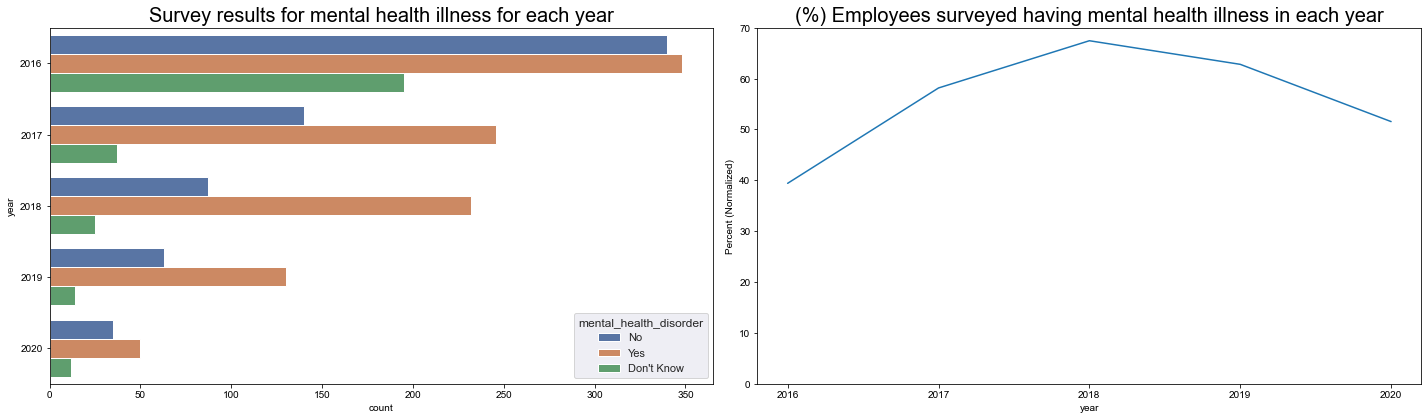

In [11]:
# Plotting graphs for visualization

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
sns.set(font_scale = 1)
ax1 = sns.countplot(y='year', hue='mental_health_disorder', data=df_filtered, ax=ax[0])
ax1.set_title('Survey results for mental health illness for each year', fontsize = 20)

ax2 = sns.lineplot(data=df_filtered_yearly_yes, x='year', y='Percent (Normalized)', ax=ax[1])
ax2.set_ylim(0, 70)
ax2.set_xticks(range(2016,2021,1)) 
ax2.set_title('(%) Employees surveyed having mental health illness in each year', fontsize = 20)
plt.tight_layout()

#fig.savefig('Trends.png', dpi = 300)

### Insights: There is a rising trend in mental health illness in IT industry from year 2016 to 2018, but decrease in recent years (2019-2020).

## Q2) What are the demographics (ie. location) of these respondents facing mental health issues?

### Visualizing the columns 'What country do you live in?' & 'Do you currently have a mental health disorder?'

In [12]:
# filter out all the null values in the column 'What country do you live in?'
# subset only the data corresponding to tech company/organization (== 'Yes') and self_employed (== 'No')

df_filtered2 = df[df['country'].notnull()]
df_filtered2 = df_filtered2[df_filtered2['tech_company']=='Yes']
df_filtered2 = df_filtered2[df_filtered2['selfemployed']=='No']
df_filtered2 = df_filtered2[df_filtered2['mental_health_disorder'] == 'Yes']
df_filtered2['country'] 

1261    United States of America
1265              United Kingdom
1267    United States of America
1270    United States of America
1272    United States of America
                  ...           
4386    United States of America
4389    United States of America
4391              United Kingdom
4394                 Philippines
4395    United States of America
Name: country, Length: 1006, dtype: object

In [13]:
# Group by 'What country do you live in?' and count the number of responses

country = df_filtered2.groupby(['country']).agg({'country': 'count'}).rename(columns={'country':'count'}).reset_index()
country.head()

,country,count
0,Afghanistan,2
1,Australia,18
2,Austria,1
3,Bangladesh,1
4,Belgium,1


In [14]:
data = dict(type = "choropleth",
            locations = country['country'],
            locationmode = 'country names',
            colorscale = "ylorbr",
            text = country["country"],
            z = country["count"],
            colorbar = {"title": 'Counts'},
           )

In [15]:
layout = dict(title = "Geographical distribution of employees with mental health illness by Country",
              geo = dict(projection = {"type": "mercator"}, 
                         showframe = False, lakecolor = 'rgb(85,173,240)'),
             )

In [16]:
choromap_country = go.Figure(data = [data], layout = layout)

In [17]:
# Plot using Plotly

iplot(choromap_country)
#choromap_country.show(renderer="png")

### Insights: Majority of the respondents surveyed are from the United States of America.

### Visualizing the columns 'What US state or territory do you live in?'  & 'Do you currently have a mental health disorder?'

In [18]:
# filter out all the null values in the column 'What US state or territory do you live in?'
# subset only the data corresponding to tech company/organization (== 'Yes') and self_employed (== 'No')

df_filtered3 = df[df['state'].notnull()]
df_filtered3 = df_filtered3[df_filtered3['tech_company']=='Yes']
df_filtered3 = df_filtered3[df_filtered3['mental_health_disorder'] == 'Yes']
df_filtered3['state'] 

1261    IL
1267    VA
1270    OR
1272    NJ
1274    GA
        ..
4364    NY
4373    MA
4386    CO
4389    MA
4395    TN
Name: state, Length: 743, dtype: object

In [19]:
# Group by 'What US state or territory do you live in?' and count the number of responses

US_States = df_filtered3.groupby(['state']).agg({'state': 'count'}).rename(columns={'state':'count'}).reset_index()
US_States.head()

,state,count
0,AK,2
1,AL,4
2,AZ,3
3,CA,107
4,CO,19


In [20]:
data = dict(type = "choropleth",
            locations = US_States['state'],
            locationmode = 'USA-states',
            colorscale = "ylorbr",
            text = US_States["state"],
            z = US_States["count"],
            colorbar = {"title": 'Counts'},
           )

In [21]:
layout = dict(title = "Geographical distribution of employees with mental health illness in US",
              geo = dict(scope='usa', showlakes = True, lakecolor = 'rgb(85,173,240)'))

In [22]:
choromap_states = go.Figure(data = [data], layout = layout)

In [23]:
# Plot using Plotly

iplot(choromap_states)
#choromap_states.show(renderer="png")

### Insights: Most of the employees surveyed are from California (US) where most IT, technological research and programming companies are situated in.

## Q3) Do respondents who have sought help for mental health issues open to discussing about it? (ie. Employer & Co-workers)

### Visualizing the columns 'Would you bring up a mental health issue with a potential employer in an interview?' & 'Why or why not?'

In [24]:
# filter out all the null values in the column 'Would you bring up a mental health issue with a potential employer in an interview?'
# subset only the data corresponding to tech company/organization (== 'Yes') and self_employed (== 'No')

df2_filtered = df[df['potential_employer_discussion'].notnull()]
df2_filtered = df2_filtered[df2_filtered['tech_company']=='Yes']
df2_filtered = df2_filtered[df2_filtered['selfemployed']=='No']
df2_filtered['potential_employer_discussion']

20         No
22         No
24         No
26         No
27      Maybe
        ...  
4391       No
4392       No
4394    Maybe
4395       No
4397      Yes
Name: potential_employer_discussion, Length: 2837, dtype: object

In [25]:
# Group by 'Would you bring up a mental health issue with a potential employer in an interview?' and count the number of responses

employer_interview = df2_filtered.groupby(['potential_employer_discussion'])['potential_employer_discussion'].count()
employer_interview

potential_employer_discussion
Maybe     673
No       1999
Yes       165
Name: potential_employer_discussion, dtype: int64

Text(0, 0.5, 'Counts')

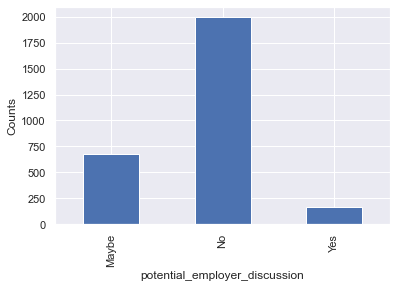

In [26]:
# Plot a bargraph for the counts (responses)

fig = plt.figure()
ax = fig.add_subplot(111)

employer_interview.plot(kind="bar")

ax.set_ylabel('Counts')

In [27]:
# filter out all the null values in the column 'Why or why not?'
# subset only the data corresponding to tech company/organization (== 'Yes')

df3_filtered = df[df['why'].notnull()]
df3_filtered = df3_filtered[df3_filtered['tech_company']=='Yes']
df3_filtered = df3_filtered[df3_filtered['selfemployed']=='No']
df3_filtered['why']

1261    It would depend on the health issue. If there ...
1262    They would provable need to know, to Judge if ...
1265    If it would potentially affect my ability to d...
1266    I want to gauge their ability to support this ...
1267                              I feel it's irrelevant.
                              ...                        
4389    Typically not relevant to being hired and fear...
4391    Nobody has ever assumed that a person is unsta...
4392    Since it involves a potential chance of losing...
4395    I don't wish to discuss physical health issues...
4397    If it is a part of me, then I would want to sh...
Name: why, Length: 1495, dtype: object

In [28]:
# clean up text by removing punctuations, numbers, and convert to lower case

df3_filtered['why'] = df3_filtered['why'].str.replace('[^\w\s]','').str.replace('\d+', '').str.lower()

In [29]:
# remove stopwords which do not add much meaning to a sentence since they occur too frequently in various contexts

def remove_stopwords(text):
    stop = set(stopwords.words('english'))
    text = [word for word in text.split() if word not in stop] 
    text = ' '.join(x for x in text) # add an empty space for every words that are not stop words
    return text

In [30]:
# apply remove_stopwords function to entire dataframe

df3_filtered['why'] = df3_filtered['why'].apply(remove_stopwords)

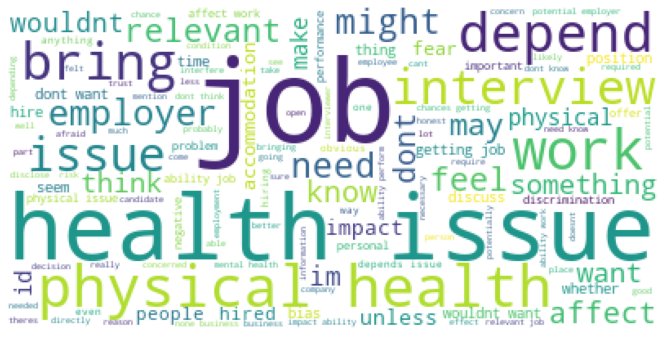

In [31]:
# Generate wordcloud plot

wordcloud2 = WordCloud(background_color="white").generate(' '.join(df3_filtered['why']))

plt.figure(figsize=(16,6))
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

#wordcloud2.to_file('Employer wordcloud3.png')

### Insights: Words like 'Discrimination', 'Bias', 'Impact ability', 'Affect work', 'Negative', 'Fear', 'Interfere', 'Stigma' are prominent in this wordcloud. This suggests that respondents have psychological fear of revealing themselves as having mental health illness to their employers.

### Visualizing the columns 'Would you feel comfortable discussing a mental health disorder with your coworkers?' & 'Describe the conversation with coworkers you had about your mental health including their reactions.'

In [32]:
# filter out all the null values in the column 'Would you feel comfortable discussing a mental health disorder with your coworkers?'
# subset only the data corresponding to tech company/organization (== 'Yes') and self_employed (== 'No')

df4_filtered = df[df['coworker_discussion'].notnull()]
df4_filtered = df4_filtered[df4_filtered['tech_company']=='Yes']
df4_filtered = df4_filtered[df4_filtered['selfemployed']=='No']
df4_filtered['coworker_discussion']

20        Yes
22        Yes
24        Yes
26        Yes
27        Yes
        ...  
4391    Maybe
4392       No
4394    Maybe
4395    Maybe
4397      Yes
Name: coworker_discussion, Length: 2837, dtype: object

In [33]:
# Group by 'Would you feel comfortable discussing a mental health disorder with your coworkers?' and count the number of responses

coworker_conversation = df4_filtered.groupby(['coworker_discussion'])['coworker_discussion'].count()
coworker_conversation

coworker_discussion
Maybe     858
No        699
Yes      1280
Name: coworker_discussion, dtype: int64

Text(0, 0.5, 'Counts')

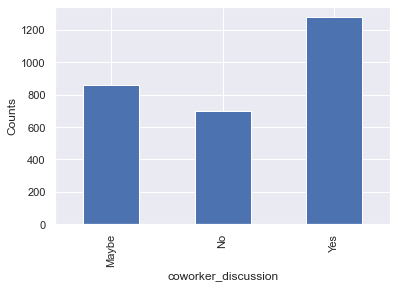

In [34]:
# Plot a bargraph for the counts (responses)

fig = plt.figure()
ax2 = fig.add_subplot(111)

coworker_conversation.plot(kind="bar")

ax2.set_ylabel('Counts')

In [35]:
# filter out all the null values in the column 'Describe the conversation with coworkers you had about your mental health including their reactions.'
# subset only the data corresponding to tech company/organization (== 'Yes') and self_employed (== 'No')

df5_filtered = df[df['coworker_conversation'].notnull()]
df5_filtered = df5_filtered[df5_filtered['tech_company']=='Yes']
df5_filtered = df5_filtered[df5_filtered['selfemployed']=='No']
df5_filtered['coworker_conversation']

2693     Spoke about my anxiety they were very supportive
2694    the coworker was comprehensive, empathetic and...
2695    They all seemed understanding and some even ad...
2696    Coworkers that have become friends with me are...
2699    I've talked about my depression with coworkers...
                              ...                        
4386    What is my condition (agoraphobia) and how it ...
4389    We regularly discuss burnout and the mental en...
4391    It wasn’t really a conversation, just dropping...
4395    It was other people who also had issues too so...
4397    At the beginning of the pandemic we were all w...
Name: coworker_conversation, Length: 392, dtype: object

In [36]:
# clean up text by removing punctuations, numbers, and convert to lower case

df5_filtered['coworker_conversation'] = df5_filtered['coworker_conversation'].str.replace('[^\w\s]','').str.replace('\d+', '').str.lower()

In [37]:
# apply remove_stopwords function to entire dataframe

df5_filtered['coworker_conversation'] = df5_filtered['coworker_conversation'].apply(remove_stopwords)

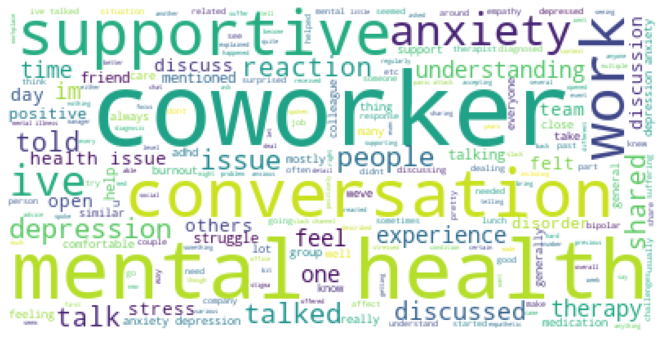

In [38]:
# Generate wordcloud plot

wordcloud3 = WordCloud(background_color="white").generate(' '.join(df5_filtered['coworker_conversation']))

plt.figure(figsize=(16,6))
plt.imshow(wordcloud3)
plt.axis("off")
plt.show()

#wordcloud3.to_file('Co-worker wordcloud3.png')

### Insights: Words like 'Supportive', 'Understanding', 'Similar', 'Positive', 'Open', 'Shared', 'Empathy' are prominent in this wordcloud. This suggests that respondents with mental health illness are more willing to share with their co-workers probably because the coworkers are also experiencing the same conditions as themselves.

## Model and Analysis Framework

## Q1) What are some of the variables that could be considered as features for correlating/predicting people at risk of mental health illness

### Generating Cramer’s V pairwise association plot for Categorical variables using dython library

In [39]:
# Out of all the categorical variables choose the categorical variables for pairwise association with
# 'mental_health_disorder'

cat_cols = [c for c in df_filtered.columns if df_filtered[c].dtypes=='O'] 
df_list = df_filtered[cat_cols].columns.to_list()

items_list = ['gender', 'family_history', 'mental_health_disorder', 'treatment', \
              'tech_role', 'num_of_employees', 'medical_leave', \
              'mental_health_benefits', 'mental_health_coverage', 'mental_health_resources', \
              'anonymity_protected', 'employer_discussion', 'potential_employer_discussion', 'coworker_discussion']

df_list_new = [value for value in df_list if value in items_list]
df_list_new

['gender',
 'family_history',
 'mental_health_disorder',
 'treatment',
 'tech_role',
 'num_of_employees',
 'medical_leave',
 'mental_health_benefits',
 'mental_health_coverage',
 'mental_health_resources',
 'anonymity_protected',
 'employer_discussion',
 'potential_employer_discussion',
 'coworker_discussion']

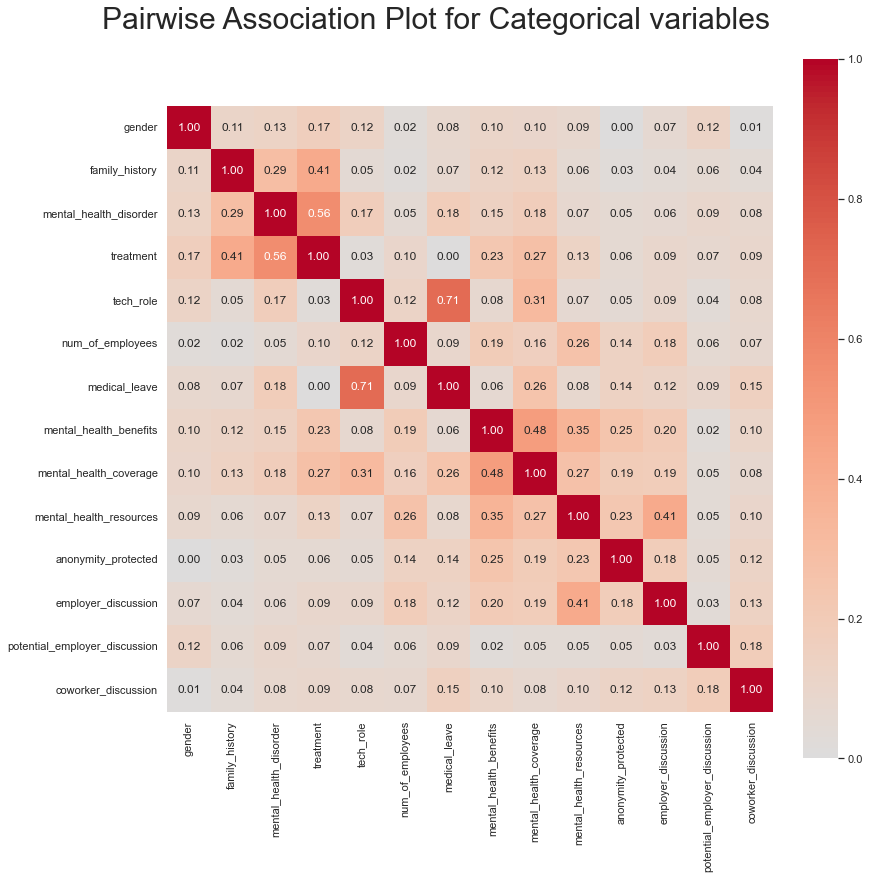

In [40]:
# Instantiate a figure and axis object
fig, ax = plt.subplots(figsize = (12, 12), constrained_layout=True)

fig.suptitle('Pairwise Association Plot for Categorical variables', fontsize = 30, ha='center', va='center')

# Estimate and generate Cramer's V association plot
cramers_v = associations(df_filtered[df_list_new],
             nom_nom_assoc = 'cramer',
             ax = ax,
             cmap = "coolwarm")

### Insights: Some of the variables that have positive association with respondents currently having mental health illness are: 1) respondents who have sought treatment for a mental health issue, 2) respondents who have a family history of mental illness, 3) gender of respondents, 4) ease of medical leave application, 5) providing medical health benefits, 6) options for medical health coverage 

## Chi-Square analysis for categorical variables

In [41]:
# keep legal and sensible working age
data_filtered = df.loc[(df['age'] > 14) & (df['age'] < 71)]

# drop self employed individuals
data_filtered = data_filtered.loc[data_filtered['selfemployed'] == 'No']

# keep target variable
data_filtered = data_filtered.loc[data_filtered['mental_health_disorder'].isin(['No', 'Yes'])]

# drop columns not required for chisq analysis
data_filtered = data_filtered.drop(['year', 'age', # keep categorical
                                    'selfemployed', # already filtered 
                                    'productivity', # many missing values
                                    'country', 'state', # not interested in location
                                    'why', 'coworker_conversation'], # because open-ended
                                    axis=1)

In [42]:
# check columns retained
print(list(data_filtered))

['gender', 'family_history', 'mental_health_disorder', 'treatment', 'tech_company', 'tech_role', 'num_of_employees', 'medical_leave', 'mental_health_benefits', 'mental_health_coverage', 'mental_health_resources', 'anonymity_protected', 'employer_discussion', 'potential_employer_discussion', 'coworker_discussion']


## More data filtering for Chi-Square analysis

In [43]:
# drop rows with NA is any column: complete case analysis approach

data_filtered = data_filtered.dropna()

# redefine categories for co size

data_filtered['num_of_employees'] = np.where(data_filtered['num_of_employees'].isin(['1-5', '6-25', '26-100']), 'S', 
                                       np.where(data_filtered['num_of_employees'].isin(['100-500', '500-1000']), 'M', 
                                                np.where(data_filtered['num_of_employees'] == 'More than 1000', 'L', '')))

In [44]:
# check categorical columns retained

for col in data_filtered.columns:
    print(col)

gender
family_history
mental_health_disorder
treatment
tech_company
tech_role
num_of_employees
medical_leave
mental_health_benefits
mental_health_coverage
mental_health_resources
anonymity_protected
employer_discussion
potential_employer_discussion
coworker_discussion


In [45]:
chisq_result = pd.DataFrame(columns=['Test', 'Statistic', 'pvalue', 'Degrees of freedom'])

In [46]:
for column in data_filtered.columns:
    if column == 'mental_health_disorder':
        continue # skip the target column
    freq_table = pd.crosstab(data_filtered['mental_health_disorder'], data_filtered[column])
    chi2_result = stats.chi2_contingency(freq_table)
    temp_df = pd.DataFrame({'Test': column,
                            'Statistic': [chi2_result[0]], 'pvalue': [chi2_result[1]], 'Degrees of freedom': [chi2_result[2]]})
    chisq_result = pd.concat([chisq_result, temp_df])
# round to two dp 
chisq_result.Statistic = chisq_result.Statistic.round(2)
chisq_result.pvalue = chisq_result.pvalue.round(2)

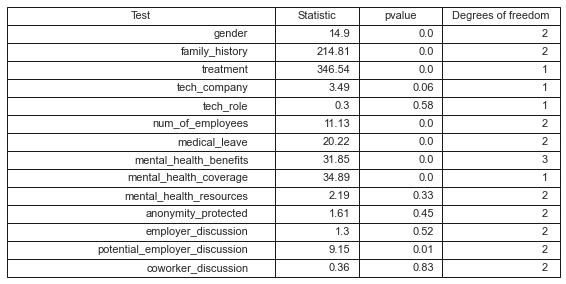

In [47]:
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
# make table
table = plt.table(cellText=chisq_result.values,
                 #cellColours=[chisq_result.color],
                  colWidths=[.8,.25,.25,.35],
                  colLabels=chisq_result.columns,
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.5)
plt.show()

## Categorical plots for relationship between variables

## Q2) Are respondents whom have sought treatment for a mental health issue currently facing mental health issues in IT industry? - based on the hypothesis that a person who has sought treatment are currently facing mental health issues in IT industry. (positive correlation case scenario for high association score = 0.56 from heatmap & Chi-square test statistics of 346.54).

### Visualizing the column 'Have you ever sought treatment for a mental health issue from a mental health professional?' 

In [48]:
# filter out all the null values in the column 'Have you ever sought treatment for a mental health issue from a mental health professional?'
# subset only the data corresponding to tech company/organization (== 'Yes') and self_employed (== 'No')

df6_filtered = df[df['treatment'].notnull()]
df6_filtered = df6_filtered[df6_filtered['tech_company']=='Yes']
df6_filtered = df6_filtered[df6_filtered['selfemployed']=='No']
df6_filtered['treatment'] 

20      Yes
22      Yes
24      Yes
26       No
27      Yes
       ... 
4391    Yes
4392     No
4394     No
4395    Yes
4397     No
Name: treatment, Length: 2837, dtype: object

In [49]:
# Group by 'Have you ever sought treatment for a mental health issue from a mental health professional?' and count the number of responses

treatment = df6_filtered.groupby(['treatment'])['treatment'].count()
treatment

treatment
No     1250
Yes    1587
Name: treatment, dtype: int64

Text(0, 0.5, 'Counts')

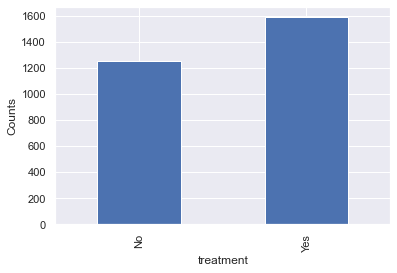

In [50]:
# Plot a bargraph for the counts (responses)

fig = plt.figure()
ax3 = fig.add_subplot(111)

treatment.plot(kind="bar")

ax3.set_ylabel('Counts')

### Visualizing the column 'Have you ever sought treatment for a mental health issue from a mental health professional?' & 'Do you currently have a mental health disorder?'

In [51]:
df6_filtered2 = df6_filtered[df6_filtered['mental_health_disorder'].notnull()]
df6_filtered2['treatment'] 

1260     No
1261    Yes
1262    Yes
1265    Yes
1266     No
       ... 
4391    Yes
4392     No
4394     No
4395    Yes
4397     No
Name: treatment, Length: 1954, dtype: object

In [52]:
# Group by 'What is your gender?' and 'Do you currently have a mental health disorder?' and count the number of responses 

treatment_trend = df6_filtered2.groupby(['treatment', 'mental_health_disorder'])['mental_health_disorder'].count()
treatment_trend

treatment  mental_health_disorder
No         Don't Know                159
           No                        495
           Yes                       149
Yes        Don't Know                124
           No                        170
           Yes                       857
Name: mental_health_disorder, dtype: int64

In [53]:
# Normalize the counts into percentages for each year and convert it into a dataframe

df_filtered_treatment = df6_filtered2.groupby(['treatment'])['mental_health_disorder'].value_counts(normalize=True).mul(100).rename('Percent (Normalized)').reset_index()
df_filtered_treatment

,treatment,mental_health_disorder,Percent (Normalized)
0,No,No,61.643836
1,No,Don't Know,19.800747
2,No,Yes,18.555417
3,Yes,Yes,74.456994
4,Yes,No,14.769765
5,Yes,Don't Know,10.773241


In [54]:
# Subset only those who gave a definite answer of either "Yes" or "No" to the questions
# 'What is your gender?' &  'Do you currently have a mental health disorder?'
# for graph plotting

df_filtered_treatment2 = df_filtered_treatment[df_filtered_treatment['mental_health_disorder'].isin(['Yes', 'No'])]
df_filtered_treatment2

,treatment,mental_health_disorder,Percent (Normalized)
0,No,No,61.643836
2,No,Yes,18.555417
3,Yes,Yes,74.456994
4,Yes,No,14.769765


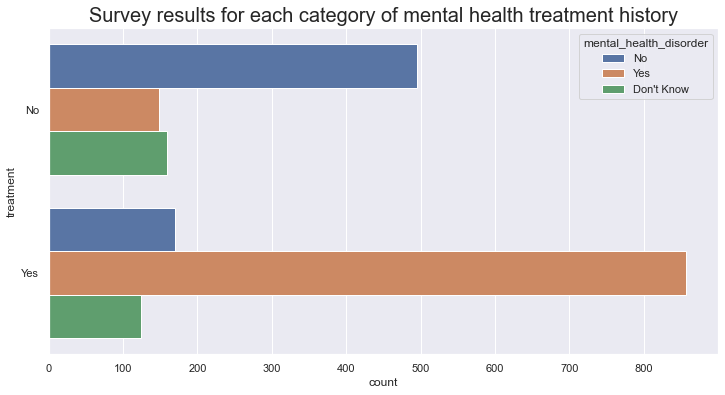

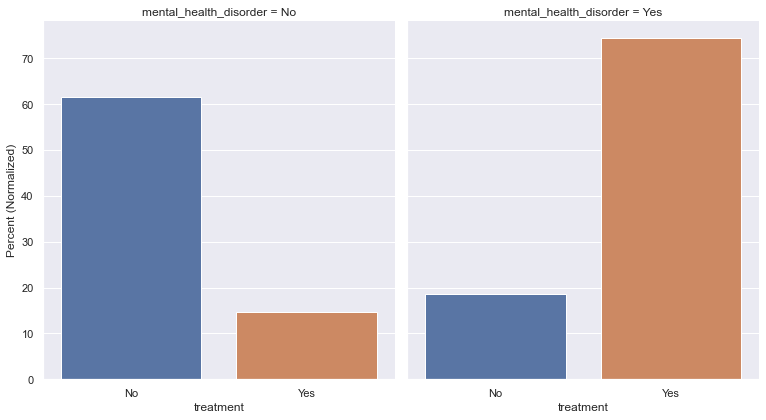

In [55]:
# Plotting graphs for visualization

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.set(font_scale = 1)
ax1 = sns.countplot(y='treatment', hue='mental_health_disorder', data=df6_filtered2)
ax1.set_title('Survey results for each category of mental health treatment history', fontsize = 20)

g = sns.catplot(data=df_filtered_treatment2, x='treatment', y="Percent (Normalized)", col='mental_health_disorder',
            kind="bar", height=6, aspect=0.9)

plt.tight_layout()
g.tight_layout()

### Insights: Respondents whom has sought treatment from mental health professional does show a tendency of having mental health disorder in IT industry, (note increased trend in 'Do you currently have a mental health disorder?' = 'Yes'). </br>Therefore, sought mental health treatment is a positive case scenario that could correlate/predict whether a person is at risk of mental health issue in IT industry.

## Q3) Are respondents with a family history of mental illness more likely to face mental health issues in IT industry? - based on the hypothesis that family background plays a role in mental health issues in IT industry (association score = 0.29 from heatmap & Chi-square test statistics of 214.81)

### Visualizing the column 'Do you have a family history of mental illness?' 

In [56]:
# filter out all the null values in the column 'Do you have a family history of mental illness?'
# subset only the data corresponding to tech company/organization (== 'Yes') and self_employed (== 'No')

df7_filtered = df[df['family_history'].notnull()]
df7_filtered = df7_filtered[df7_filtered['tech_company']=='Yes']
df7_filtered = df7_filtered[df7_filtered['selfemployed']=='No']
df7_filtered['family_history'] 

20      Yes
22       No
24      Yes
26       No
27      Yes
       ... 
4391    Yes
4392     No
4394     No
4395    Yes
4397     No
Name: family_history, Length: 2837, dtype: object

In [57]:
# Group by 'Do you have a family history of mental illness?' and count the number of responses

family_history = df7_filtered.groupby(['family_history'])['family_history'].count()
family_history

family_history
I don't know     411
No              1191
Yes             1235
Name: family_history, dtype: int64

Text(0, 0.5, 'Counts')

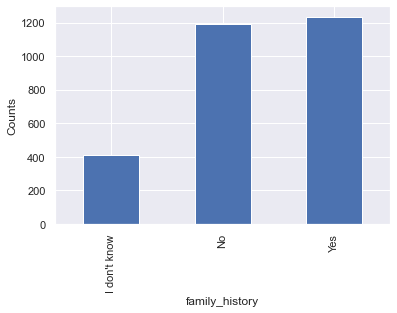

In [58]:
# Plot a bargraph for the counts (responses)

fig = plt.figure()
ax3 = fig.add_subplot(111)

family_history.plot(kind="bar")

ax3.set_ylabel('Counts')

### Visualizing the column 'Do you have a family history of mental illness?' & 'Do you currently have a mental health disorder?'

In [59]:
df7_filtered2 = df7_filtered[df7_filtered['mental_health_disorder'].notnull()]
df7_filtered2['family_history'] 

1260     No
1261    Yes
1262     No
1265     No
1266     No
       ... 
4391    Yes
4392     No
4394     No
4395    Yes
4397     No
Name: family_history, Length: 1954, dtype: object

In [60]:
# Group by 'Do you have a family history of mental illness?' and 'Do you currently have a mental health disorder?' and count the number of responses 

family_history_trend = df7_filtered2.groupby(['family_history', 'mental_health_disorder'])['mental_health_disorder'].count()
family_history_trend

family_history  mental_health_disorder
I don't know    Don't Know                 88
                No                         94
                Yes                       229
No              Don't Know                 91
                No                        384
                Yes                       165
Yes             Don't Know                104
                No                        187
                Yes                       612
Name: mental_health_disorder, dtype: int64

In [61]:
# Normalize the counts into percentages for each year and convert it into a dataframe

df_filtered_family_history = df7_filtered2.groupby(['family_history'])['mental_health_disorder'].value_counts(normalize=True).mul(100).rename('Percent (Normalized)').reset_index()
df_filtered_family_history

,family_history,mental_health_disorder,Percent (Normalized)
0,I don't know,Yes,55.717762
1,I don't know,No,22.871046
2,I don't know,Don't Know,21.411192
3,No,No,60.000000
4,No,Yes,25.781250
5,No,Don't Know,14.218750
6,Yes,Yes,67.774086
7,Yes,No,20.708749
8,Yes,Don't Know,11.517165


In [62]:
# Subset only those who gave a definite answer of either "Yes" or "No" to the questions
# 'Do you have a family history of mental illness?' &  'Do you currently have a mental health disorder?'
# for graph plotting

df_filtered_family_history2 = df_filtered_family_history[df_filtered_family_history['mental_health_disorder'].isin(['Yes', 'No'])]
df_filtered_family_history2 = df_filtered_family_history2[df_filtered_family_history2['family_history'].isin(['Yes', 'No'])]
df_filtered_family_history2

,family_history,mental_health_disorder,Percent (Normalized)
3,No,No,60.000000
4,No,Yes,25.781250
6,Yes,Yes,67.774086
7,Yes,No,20.708749


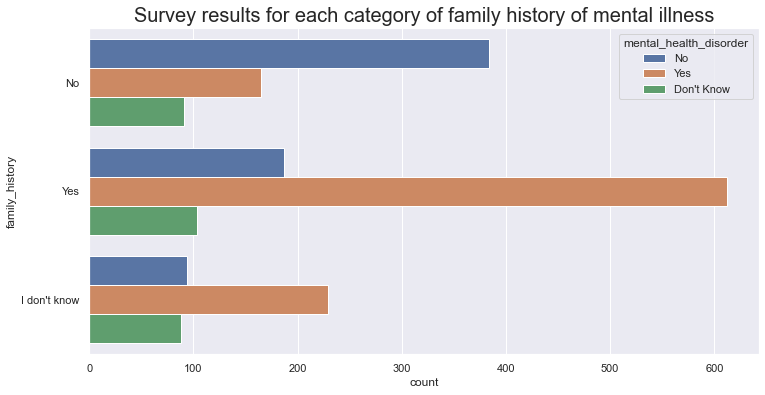

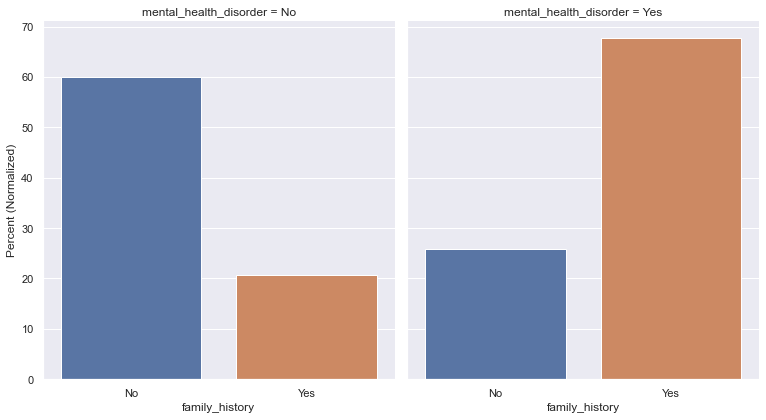

In [63]:
# Plotting graphs for visualization

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.set(font_scale = 1)
ax1 = sns.countplot(y='family_history', hue='mental_health_disorder', data=df7_filtered2)
ax1.set_title('Survey results for each category of family history of mental illness', fontsize = 20)

g = sns.catplot(data=df_filtered_family_history2, x='family_history', y="Percent (Normalized)", col='mental_health_disorder',
            kind="bar", height=6, aspect=.9)

plt.tight_layout()
g.tight_layout()

### Insights: Respondents having a family history of mental illness does show a tendency of having a mental health disorder in IT industry (note increased trend in 'Do you currently have a mental health disorder?' = 'Yes'). </br> Therefore, family history is a feature that could correlate/predict whether a person is at risk of mental health issue in IT industry.

## Q4) Are respondents with a primary role in tech/IT more likely to face mental health issues in IT industry?  - based on the hypothesis that IT jobscope plays a role in mental health issues in IT industry (association score = 0.17 from heatmap & Chi-square test statistics of 0.3) 

### Visualizing the column 'Is your primary role within your company related to tech/IT?' 

In [64]:
# filter out all the null values in the column 'Is your primary role within your company related to tech/IT?'
# subset only the data corresponding to tech company/organization (== 'Yes') and self_employed (== 'No')

df8_filtered = df[df['tech_role'].notnull()]
df8_filtered = df8_filtered[df8_filtered['tech_company']=='Yes']
df8_filtered = df8_filtered[df8_filtered['selfemployed']=='No']
df8_filtered['tech_role'] 

2693    Yes
2694    Yes
2695    Yes
2696    Yes
2698     No
       ... 
4391    Yes
4392    Yes
4394    Yes
4395    Yes
4397    Yes
Name: tech_role, Length: 1071, dtype: object

In [65]:
# Group by 'Is your primary role within your company related to tech/IT?' and count the number of responses

primary_role = df8_filtered.groupby(['tech_role'])['tech_role'].count()
primary_role

tech_role
No       66
Yes    1005
Name: tech_role, dtype: int64

Text(0, 0.5, 'Counts')

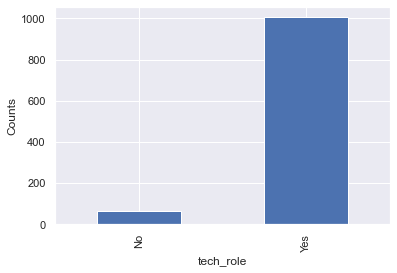

In [66]:
# Plot a bargraph for the counts (responses)

fig = plt.figure()
ax3 = fig.add_subplot(111)

primary_role.plot(kind="bar")

ax3.set_ylabel('Counts')

### Visualizing the column 'Is your primary role within your company related to tech/IT?' & 'Do you currently have a mental health disorder?'

In [67]:
df8_filtered2 = df8_filtered[df8_filtered['mental_health_disorder'].notnull()]
df8_filtered2['tech_role'] 

2693    Yes
2694    Yes
2695    Yes
2696    Yes
2698     No
       ... 
4391    Yes
4392    Yes
4394    Yes
4395    Yes
4397    Yes
Name: tech_role, Length: 1071, dtype: object

In [68]:
# Group by 'Is your primary role within your company related to tech/IT?' and 'Do you currently have a mental health disorder?' and count the number of responses 

primary_role_trend = df8_filtered2.groupby(['tech_role', 'mental_health_disorder'])['mental_health_disorder'].count()
primary_role_trend

tech_role  mental_health_disorder
No         Don't Know                  1
           No                         19
           Yes                        46
Yes        Don't Know                 87
           No                        306
           Yes                       612
Name: mental_health_disorder, dtype: int64

In [69]:
# Normalize the counts into percentages for each year and convert it into a dataframe

df_filtered_primary_role = df8_filtered2.groupby(['tech_role'])['mental_health_disorder'].value_counts(normalize=True).mul(100).rename('Percent (Normalized)').reset_index()
df_filtered_primary_role

,tech_role,mental_health_disorder,Percent (Normalized)
0,No,Yes,69.696970
1,No,No,28.787879
2,No,Don't Know,1.515152
3,Yes,Yes,60.895522
4,Yes,No,30.447761
5,Yes,Don't Know,8.656716


In [70]:
# Subset only those who gave a definite answer of either "Yes" or "No" to the questions
# 'Is your primary role within your company related to tech/IT?' &  'Do you currently have a mental health disorder?'
# for graph plotting

df_filtered_primary_role2 = df_filtered_primary_role[df_filtered_primary_role['mental_health_disorder'].isin(['Yes', 'No'])]
df_filtered_primary_role2 = df_filtered_primary_role2[df_filtered_primary_role2['tech_role'].isin(['Yes', 'No'])]
df_filtered_primary_role2

,tech_role,mental_health_disorder,Percent (Normalized)
0,No,Yes,69.696970
1,No,No,28.787879
3,Yes,Yes,60.895522
4,Yes,No,30.447761


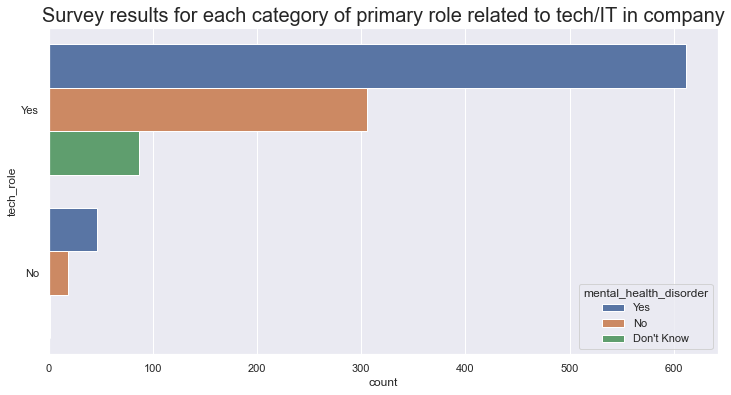

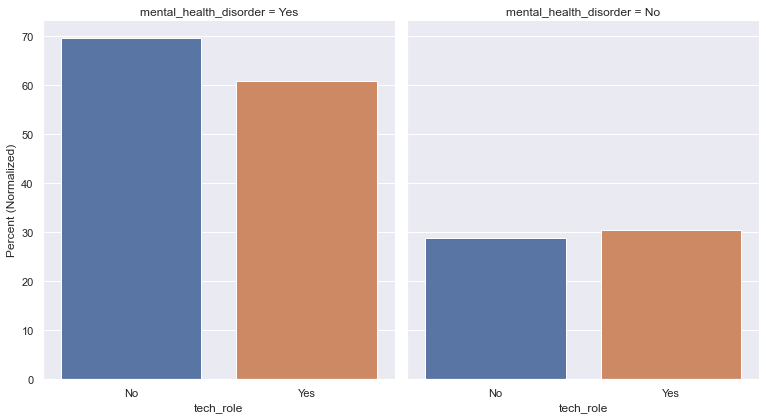

In [71]:
# Plotting graphs for visualization

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.set(font_scale = 1)
ax1 = sns.countplot(y='tech_role', hue='mental_health_disorder', data=df8_filtered2)
ax1.set_title('Survey results for each category of primary role related to tech/IT in company', fontsize = 20)

g = sns.catplot(data=df_filtered_primary_role2, x='tech_role', y="Percent (Normalized)", col='mental_health_disorder',
            kind="bar", height=6, aspect=.9)

plt.tight_layout()
g.tight_layout()

### Insights: whether the primary role of respondents within the company is related to tech/IT or not does NOT show a tendency of having a mental health disorder in IT industry (note similar trend in 'Do you currently have a mental health disorder?' = 'Yes').</br> Therefore, primary role related to tech/IT is NOT a feature that could correlate/predict whether a person is at risk of mental health issue in IT industry.

## Q5) Are respondents of different gender more likely to face mental health issues in IT industry?  - based on the hypothesis that gender plays a role in mental health issues in IT industry (association score = 0.13 from heatmap & Chi-square test statistics of 14.9)

### Visualizing the column 'What is your gender?' 

In [72]:
# filter out all the null values in the column 'What is your gender?'
# subset only the data corresponding to tech company/organization (== 'Yes') and self_employed (== 'No')

df9_filtered = df[df['gender'].notnull()]
df9_filtered = df9_filtered[df9_filtered['tech_company']=='Yes']
df9_filtered = df9_filtered[df9_filtered['selfemployed']=='No']
df9_filtered['gender'] 

20        male
22        male
24        male
26        male
27      female
         ...  
4391    female
4392      male
4394    female
4395      male
4397      male
Name: gender, Length: 2837, dtype: object

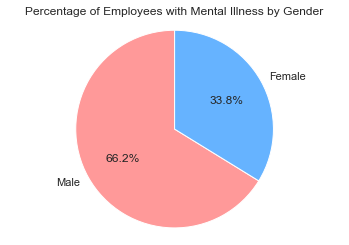

In [73]:
# Select rows where 'Do you currently have a mental health disorder?' is 'Yes'
mental_illness = df9_filtered[df9_filtered['mental_health_disorder'] == 'Yes']

# Count the number of males and females with mental illness
male_count = mental_illness[mental_illness['gender'] == 'male'].shape[0]
female_count = mental_illness[mental_illness['gender'] == 'female'].shape[0]

# Create a pie chart to show the percentage of males and females with mental illness
labels = ['Male', 'Female']
sizes = [male_count, female_count]
colors = ['#ff9999','#66b3ff']

plt.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Percentage of Employees with Mental Illness by Gender')
plt.show()

### Visualizing the column 'What is your gender?' & 'Do you currently have a mental health disorder?'

In [74]:
df9_filtered2 = df9_filtered[df9_filtered['mental_health_disorder'].notnull()]
df9_filtered2['gender'] 

1260      male
1261      male
1262    others
1265      male
1266      male
         ...  
4391    female
4392      male
4394    female
4395      male
4397      male
Name: gender, Length: 1954, dtype: object

In [75]:
# Group by 'What is your gender?' and 'Do you currently have a mental health disorder?' and count the number of responses 

gender_trend = df9_filtered2.groupby(['gender', 'mental_health_disorder'])['mental_health_disorder'].count()
gender_trend

gender  mental_health_disorder
female  Don't Know                 49
        No                        134
        Yes                       303
male    Don't Know                220
        No                        498
        Yes                       594
others  Don't Know                 14
        No                         33
        Yes                       109
Name: mental_health_disorder, dtype: int64

In [76]:
# Normalize the counts into percentages for each year and convert it into a dataframe

df_filtered_gender = df9_filtered2.groupby(['gender'])['mental_health_disorder'].value_counts(normalize=True).mul(100).rename('Percent (Normalized)').reset_index()
df_filtered_gender

,gender,mental_health_disorder,Percent (Normalized)
0,female,Yes,62.345679
1,female,No,27.572016
2,female,Don't Know,10.082305
3,male,Yes,45.274390
4,male,No,37.957317
5,male,Don't Know,16.768293
6,others,Yes,69.871795
7,others,No,21.153846
8,others,Don't Know,8.974359


In [77]:
# Subset only those who gave a definite answer of either "Yes" or "No" to the questions
# 'What is your gender?' &  'Do you currently have a mental health disorder?'
# for graph plotting

df_filtered_gender2 = df_filtered_gender[df_filtered_gender['mental_health_disorder'].isin(['Yes', 'No'])]
df_filtered_gender2 = df_filtered_gender2[df_filtered_gender2['gender'].isin(['male', 'female'])]
df_filtered_gender2

,gender,mental_health_disorder,Percent (Normalized)
0,female,Yes,62.345679
1,female,No,27.572016
3,male,Yes,45.274390
4,male,No,37.957317


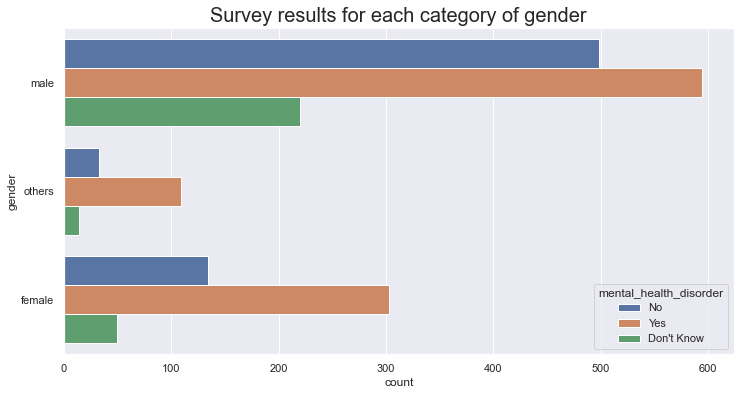

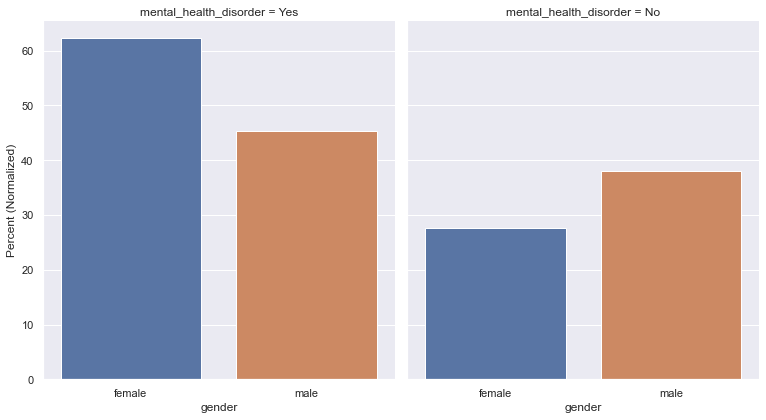

In [78]:
# Plotting graphs for visualization

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.set(font_scale = 1)
ax1 = sns.countplot(y='gender', hue='mental_health_disorder', data=df9_filtered2)
ax1.set_title('Survey results for each category of gender', fontsize = 20)

g = sns.catplot(data=df_filtered_gender2, x='gender', y="Percent (Normalized)", col='mental_health_disorder',
            kind="bar", height=6, aspect=.9)

plt.tight_layout()
g.tight_layout()

### Insights: A female respondent does show a tendency of having a mental health disorder in IT industry, (note increased trend in 'Do you currently have a mental health disorder?' = 'Yes'). </br>Therefore, gender is a feature that could correlate/predict whether a person is at risk of mental health issue in IT industry.

## Q6) Are respondents in large company size more likely to face mental health issues  in IT industry?  - based on the hypothesis that company size (business scope) plays a role in mental health issues in IT industry (association score = 0.05 from heatmap & Chi-square test statistics of 11.13)

### Visualizing the column 'How many employees does your company or organization have?' 

In [79]:
# filter out all the null values in the column 'How many employees does your company or organization have?'
# subset only the data corresponding to tech company/organization (== 'Yes') and self_employed (== 'No')

df10_filtered = df[df['num_of_employees'].notnull()]
df10_filtered = df10_filtered[df10_filtered['tech_company']=='Yes']
df10_filtered = df10_filtered[df10_filtered['selfemployed']=='No']
df10_filtered['num_of_employees'] 

20             100-500
22              26-100
24              26-100
26                 1-5
27                6-25
             ...      
4391            26-100
4392    More than 1000
4394            26-100
4395           100-500
4397          500-1000
Name: num_of_employees, Length: 2837, dtype: object

In [80]:
# Group by 'How many employees does your company or organization have?' and count the number of responses

company_size = df10_filtered.groupby(['num_of_employees'])['num_of_employees'].count()
company_size

num_of_employees
1-5               140
100-500           643
26-100            709
500-1000          179
6-25              590
More than 1000    576
Name: num_of_employees, dtype: int64

Text(0, 0.5, 'Counts')

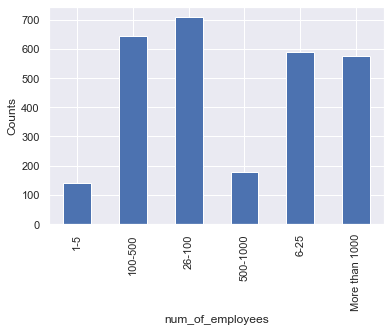

In [81]:
# Plot a bargraph for the counts (responses)

fig = plt.figure()
ax3 = fig.add_subplot(111)

company_size.plot(kind="bar")

ax3.set_ylabel('Counts')

### Visualizing the column 'How many employees does your company or organization have?' & 'Do you currently have a mental health disorder?'

In [82]:
df10_filtered2 = df10_filtered[df10_filtered['mental_health_disorder'].notnull()]
df10_filtered2['num_of_employees'] 

1260            26-100
1261              6-25
1262              6-25
1265    More than 1000
1266            26-100
             ...      
4391            26-100
4392    More than 1000
4394            26-100
4395           100-500
4397          500-1000
Name: num_of_employees, Length: 1954, dtype: object

In [83]:
# Group by 'How many employees does your company or organization have?' and 'Do you currently have a mental health disorder?' and count the number of responses 

company_size_trend = df10_filtered2.groupby(['num_of_employees', 'mental_health_disorder'])['mental_health_disorder'].count()
company_size_trend

num_of_employees  mental_health_disorder
1-5               Don't Know                 12
                  No                         36
                  Yes                        34
100-500           Don't Know                 77
                  No                        157
                  Yes                       279
26-100            Don't Know                 68
                  No                        181
                  Yes                       229
500-1000          Don't Know                 19
                  No                         41
                  Yes                        79
6-25              Don't Know                 54
                  No                        136
                  Yes                       165
More than 1000    Don't Know                 53
                  No                        114
                  Yes                       220
Name: mental_health_disorder, dtype: int64

In [84]:
# Normalize the counts into percentages for each year and convert it into a dataframe

df_filtered_company_size = df10_filtered2.groupby(['num_of_employees'])['mental_health_disorder'].value_counts(normalize=True).mul(100).rename('Percent (Normalized)').reset_index()
df_filtered_company_size

,num_of_employees,mental_health_disorder,Percent (Normalized)
0,1-5,No,43.902439
1,1-5,Yes,41.463415
2,1-5,Don't Know,14.634146
3,100-500,Yes,54.385965
4,100-500,No,30.604288
5,100-500,Don't Know,15.009747
6,26-100,Yes,47.907950
7,26-100,No,37.866109
8,26-100,Don't Know,14.225941
9,500-1000,Yes,56.834532


In [85]:
# Subset only those who gave a definite answer of either "Yes" or "No" to the questions
# 'How many employees does your company or organization have?' &  'Do you currently have a mental health disorder?'
# for graph plotting

df_filtered_company_size2 = df_filtered_company_size[df_filtered_company_size['mental_health_disorder'].isin(['Yes', 'No'])]
df_filtered_company_size2

,num_of_employees,mental_health_disorder,Percent (Normalized)
0,1-5,No,43.902439
1,1-5,Yes,41.463415
3,100-500,Yes,54.385965
4,100-500,No,30.604288
6,26-100,Yes,47.907950
7,26-100,No,37.866109
9,500-1000,Yes,56.834532
10,500-1000,No,29.496403
12,6-25,Yes,46.478873
13,6-25,No,38.309859


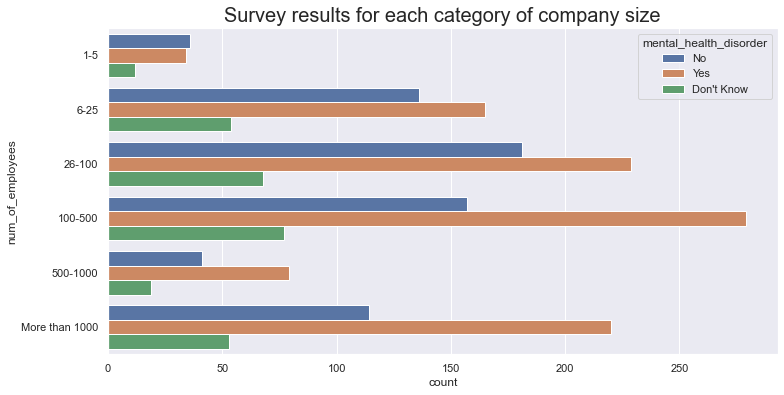

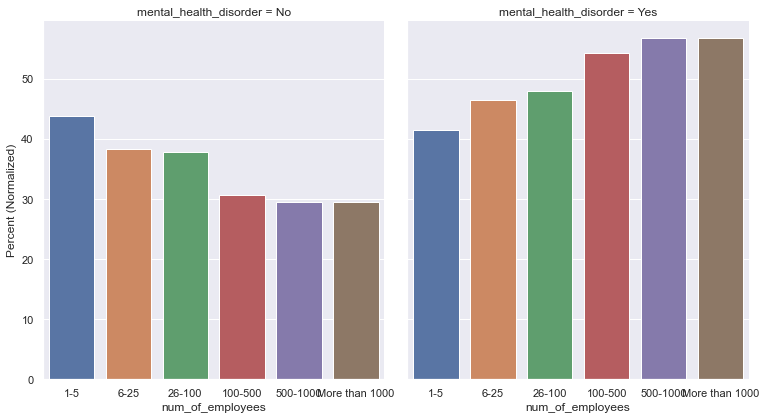

In [86]:
# Plotting graphs for visualization

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.set(font_scale = 1)
ax1 = sns.countplot(y='num_of_employees', hue='mental_health_disorder', data=df10_filtered2, order=['1-5','6-25','26-100', '100-500', '500-1000', 'More than 1000'])
ax1.set_title('Survey results for each category of company size', fontsize = 20)

g = sns.catplot(data=df_filtered_company_size2, x='num_of_employees', y="Percent (Normalized)", col='mental_health_disorder',
            kind="bar", height=6, aspect=.9, order=['1-5','6-25','26-100', '100-500', '500-1000', 'More than 1000'])

plt.tight_layout()
g.tight_layout()

### Insights: A large company size (large and varied business scope) does show a tendency of respondents having a mental health disorder in IT industry, (note increasing trend in 'Do you currently have a mental health disorder?' = 'Yes'). </br> Therefore, company size is a feature that could correlate/predict whether a person is at risk of mental health issue in IT industry.

## Q7) Are respondents of different age group more likely to face mental health issues in IT industry?  - based on the hypothesis that age plays a role in mental health issues in IT industry

### Visualizing the column 'What is your age?' 

In [87]:
# filter out all the null values in the column 'What is your age?'
# subset only the data corresponding to tech company/organization (== 'Yes') and self_employed (== 'No')

df11_filtered = df[df['age'].notnull()]
df11_filtered = df11_filtered[df11_filtered['tech_company']=='Yes']
df11_filtered = df11_filtered[df11_filtered['selfemployed']=='No']
df11_filtered['age'] 

20      29.0
22      46.0
24      33.0
26      33.0
27      35.0
        ... 
4391    40.0
4392    31.0
4394    23.0
4395    34.0
4397    37.0
Name: age, Length: 2837, dtype: float64

In [88]:
# Group by 'What is your age?' and count the number of responses

age = df11_filtered.groupby(['age'])['age'].count()
age.head()

age
3.0      1
5.0      1
17.0     1
18.0     6
19.0    12
Name: age, dtype: int64

In [89]:
# retrieve the index of the outliers in the column 'What is your age?' 
# locate the outliers using the index and replace it with NaN

df11_filtered.index[df11_filtered['age'].isin([-1.000000e+00, 3.000000e+00, 5.000000e+00, 8.000000e+00, 9.900000e+01, 3.230000e+02, 3.290000e+02, 1.000000e+11])].tolist()
df11_filtered['age'].loc[[364, 734, 1632, 1824, 1916]] = np.nan
df11_filtered['age'].loc[[364, 734, 1632, 1824, 1916]]

364    NaN
734    NaN
1632   NaN
1824   NaN
1916   NaN
Name: age, dtype: float64

In [90]:
# calculate the median of age 

median_age = df11_filtered['age'].median()

# Replace the outliers with median of age values

df11_filtered['age'].replace(np.nan, median_age, inplace=True)

# Check that the outliers have been replaced with median of age values

df11_filtered['age'].loc[[364, 734, 1632, 1824, 1916]]

364     32.0
734     32.0
1632    32.0
1824    32.0
1916    32.0
Name: age, dtype: float64

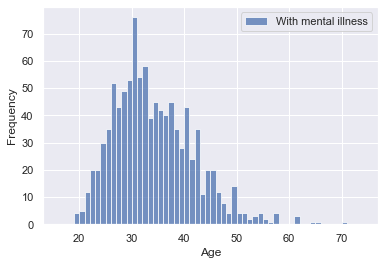

In [91]:
with_mental_illness = df11_filtered[df11_filtered['mental_health_disorder'] == 'Yes']

# create histograms of age 
fig, ax = plt.subplots()
ax.hist(with_mental_illness['age'], bins=range(16,75,1), alpha=0.75, label='With mental illness')
ax.set_xlabel('Age')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()

For the column 'What is your age?', bin each row of data based on the following criteria:</br>
`1:   17 <= age < 30 ` </br>
`2:   31 <= age < 50 ` </br>
`3:   51 <= age < 71 ` </br>

In [92]:
# create a list of integers 1-5 and assign it to a variable, bin_labels

bin_labels = ['17-30', '31-50', '51-71']

# use pd.cut() function to bin values in 'What is your age?' column into discrete intervals of 25 years old
# with labels = bin_labels

df11_filtered['age'] = pd.cut(x=df11_filtered['age'], bins=[16, 30, 50, 71], labels = bin_labels)

# check if the column 'What is your age?' has been binned
df11_filtered['age']

20      17-30
22      31-50
24      31-50
26      31-50
27      31-50
        ...  
4391    31-50
4392    31-50
4394    17-30
4395    31-50
4397    31-50
Name: age, Length: 2837, dtype: category
Categories (3, object): ['17-30' < '31-50' < '51-71']

In [93]:
# Group by 'What is your age?' and count the number of responses

age = df11_filtered.groupby(['age'])['age'].count()
age

age
17-30    1206
31-50    1563
51-71      68
Name: age, dtype: int64

Text(0, 0.5, 'Counts')

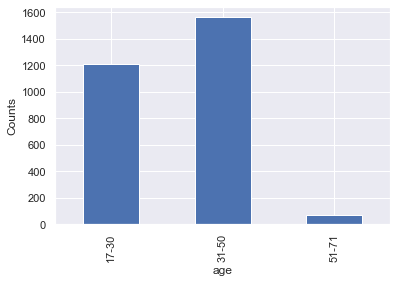

In [94]:
# Plot a bargraph for the counts (responses)

fig = plt.figure()
ax3 = fig.add_subplot(111)

age.plot(kind="bar")

ax3.set_ylabel('Counts')

### Visualizing the column 'What is your age?' & 'Do you currently have a mental health disorder?'

In [95]:
df11_filtered2 = df11_filtered[df10_filtered['mental_health_disorder'].notnull()]
df11_filtered2['age'] 

1260    31-50
1261    17-30
1262    31-50
1265    31-50
1266    17-30
        ...  
4391    31-50
4392    31-50
4394    17-30
4395    31-50
4397    31-50
Name: age, Length: 1954, dtype: category
Categories (3, object): ['17-30' < '31-50' < '51-71']

In [96]:
# Group by 'What is your age?' and 'Do you currently have a mental health disorder?' and count the number of responses 

age_trend = df11_filtered2.groupby(['age', 'mental_health_disorder'])['mental_health_disorder'].count()
age_trend

age    mental_health_disorder
17-30  Don't Know                122
       No                        255
       Yes                       399
31-50  Don't Know                158
       No                        388
       Yes                       581
51-71  Don't Know                  3
       No                         22
       Yes                        26
Name: mental_health_disorder, dtype: int64

In [97]:
# Normalize the counts into percentages for each year and convert it into a dataframe

df_filtered_age = df11_filtered2.groupby(['age'])['mental_health_disorder'].value_counts(normalize=True).mul(100).rename('Percent (Normalized)').reset_index()
df_filtered_age

,age,mental_health_disorder,Percent (Normalized)
0,17-30,Yes,51.417526
1,17-30,No,32.860825
2,17-30,Don't Know,15.721649
3,31-50,Yes,51.552795
4,31-50,No,34.427684
5,31-50,Don't Know,14.019521
6,51-71,Yes,50.980392
7,51-71,No,43.137255
8,51-71,Don't Know,5.882353


In [98]:
# Subset only those who gave a definite answer of either "Yes" or "No" to the questions
# 'What is your age?' &  'Do you currently have a mental health disorder?'
# for graph plotting

df_filtered_age2 = df_filtered_age[df_filtered_age['mental_health_disorder'].isin(['Yes', 'No'])]
df_filtered_age2 = df_filtered_age2[df_filtered_age2['age'].isin(['17-30', '31-50', '51-71'])]
df_filtered_age2

,age,mental_health_disorder,Percent (Normalized)
0,17-30,Yes,51.417526
1,17-30,No,32.860825
3,31-50,Yes,51.552795
4,31-50,No,34.427684
6,51-71,Yes,50.980392
7,51-71,No,43.137255


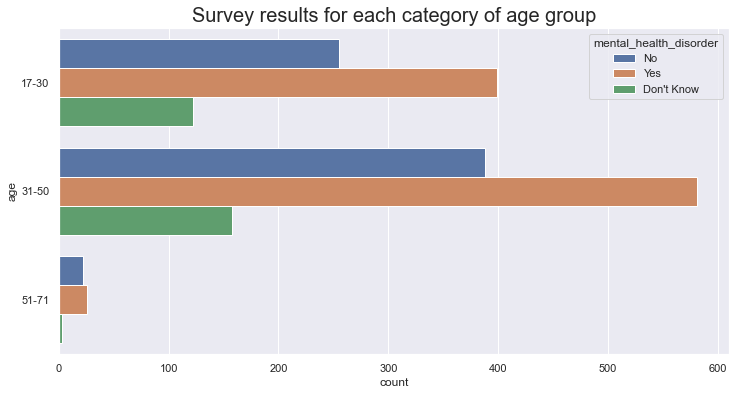

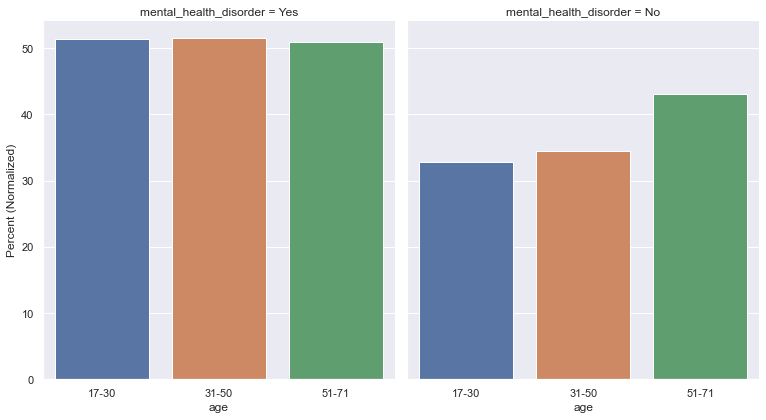

In [99]:
# Plotting graphs for visualization

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.set(font_scale = 1)
ax1 = sns.countplot(y='age', hue='mental_health_disorder', data=df11_filtered2)
ax1.set_title('Survey results for each category of age group', fontsize = 20)

g = sns.catplot(data=df_filtered_age2, x='age', y="Percent (Normalized)", col='mental_health_disorder',
            kind="bar", height=6, aspect=.9)

plt.tight_layout()
g.tight_layout()

### Insights: whether the respondent is young or old does NOT show a tendency of having a mental health disorder in IT industry, (note similar trend in 'Do you currently have a mental health disorder?' = 'Yes'). </br>Therefore, age is NOT a feature that could correlate/predict whether a person is at risk of mental health issue in IT industry.

## Q8) Are respondents with mental health issues having difficulty in applying medical leave in IT industry?  - based on the hypothesis that ease of medical leave application plays a role in mental health issues in IT industry (association score = 0.18 from heatmap & Chi-square test statistics of 20.22) 

### Visualizing the column 'If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?' 

In [100]:
# filter out all the null values in the column 'If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?'
# subset only the data corresponding to tech company/organization (== 'Yes') and self_employed (== 'No')

df12_filtered = df[df['medical_leave'].notnull()]
df12_filtered = df12_filtered[df12_filtered['tech_company']=='Yes']
df12_filtered = df12_filtered[df12_filtered['selfemployed']=='No']
df12_filtered['medical_leave'] 

20       Difficult
22      Don't know
24      Don't know
26      Don't know
27      Don't know
           ...    
4391     Difficult
4392          Easy
4394          Easy
4395          Easy
4397          Easy
Name: medical_leave, Length: 1954, dtype: object

In [101]:
# Group by 'If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?' 
# and count the number of responses

medical_leave = df12_filtered.groupby(['medical_leave'])['medical_leave'].count()
medical_leave

medical_leave
Difficult     331
Don't know    737
Easy          886
Name: medical_leave, dtype: int64

Text(0, 0.5, 'Counts')

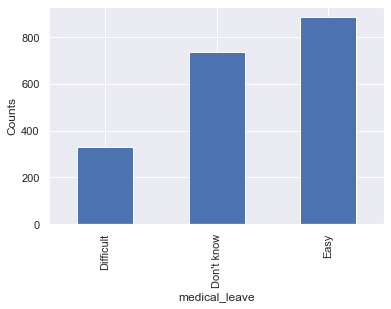

In [102]:
# Plot a bargraph for the counts (responses)

fig = plt.figure()
ax3 = fig.add_subplot(111)

medical_leave.plot(kind="bar")

ax3.set_ylabel('Counts')

### Visualizing the column ''If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?'' & 'Do you currently have a mental health disorder?'

In [103]:
df12_filtered2 = df12_filtered[df12_filtered['mental_health_disorder'].notnull()]
df12_filtered2['medical_leave'] 

2693    Don't know
2694    Don't know
2695     Difficult
2696     Difficult
2698          Easy
           ...    
4391     Difficult
4392          Easy
4394          Easy
4395          Easy
4397          Easy
Name: medical_leave, Length: 1071, dtype: object

In [104]:
# Group by 'If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?' 
# and 'Do you currently have a mental health disorder?' and count the number of responses 

medical_leave_trend = df12_filtered2.groupby(['medical_leave', 'mental_health_disorder'])['mental_health_disorder'].count()
medical_leave_trend

medical_leave  mental_health_disorder
Difficult      Don't Know                 16
               No                         43
               Yes                       138
Don't know     Don't Know                 29
               No                         87
               Yes                       198
Easy           Don't Know                 43
               No                        195
               Yes                       322
Name: mental_health_disorder, dtype: int64

In [105]:
# Normalize the counts into percentages for each year and convert it into a dataframe

df_filtered_medical_leave = df12_filtered2.groupby(['medical_leave'])['mental_health_disorder'].value_counts(normalize=True).mul(100).rename('Percent (Normalized)').reset_index()
df_filtered_medical_leave

,medical_leave,mental_health_disorder,Percent (Normalized)
0,Difficult,Yes,70.050761
1,Difficult,No,21.827411
2,Difficult,Don't Know,8.121827
3,Don't know,Yes,63.057325
4,Don't know,No,27.707006
5,Don't know,Don't Know,9.235669
6,Easy,Yes,57.500000
7,Easy,No,34.821429
8,Easy,Don't Know,7.678571


In [106]:
# Subset only those who gave a definite answer of either "Yes" or "No" to the questions
# 'If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?'
# &  'Do you currently have a mental health disorder?'
# for graph plotting

df_filtered_medical_leave2 = df_filtered_medical_leave[df_filtered_medical_leave['mental_health_disorder'].isin(['Yes', 'No'])]
df_filtered_medical_leave2 = df_filtered_medical_leave2[df_filtered_medical_leave2['medical_leave'].isin(['Difficult', 'Easy'])]
df_filtered_medical_leave2

,medical_leave,mental_health_disorder,Percent (Normalized)
0,Difficult,Yes,70.050761
1,Difficult,No,21.827411
6,Easy,Yes,57.500000
7,Easy,No,34.821429


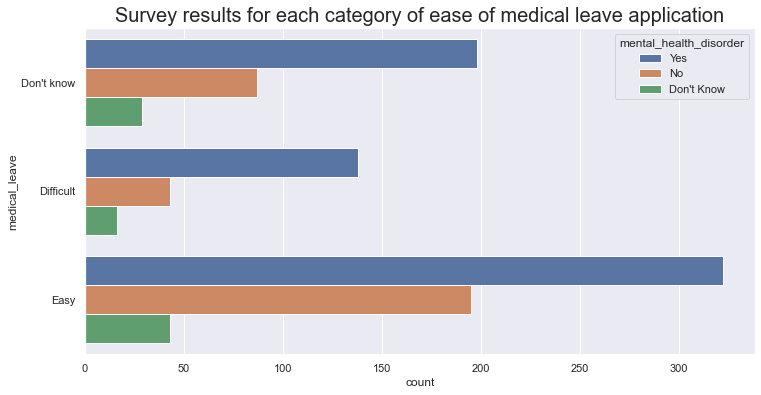

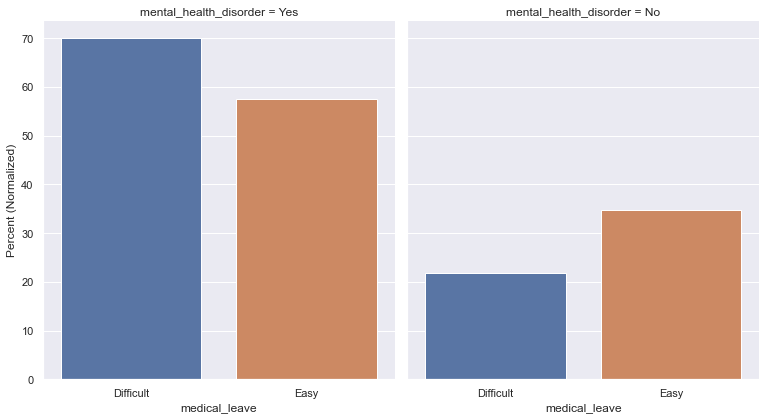

In [107]:
# Plotting graphs for visualization

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.set(font_scale = 1)
ax1 = sns.countplot(y='medical_leave', hue='mental_health_disorder', data=df12_filtered2)
ax1.set_title('Survey results for each category of ease of medical leave application', fontsize = 20)

g = sns.catplot(data=df_filtered_medical_leave2, x='medical_leave', y="Percent (Normalized)", col='mental_health_disorder',
            kind="bar", height=6, aspect=.9)

plt.tight_layout()
g.tight_layout()

### Insights: Respondents with mental health illness are having difficulty in applying medical leave (note increased trend in 'Do you currently have a mental health disorder?' = 'Yes'). </br> Therefore, ease of medical leave application is a feature that could help support a person at risk of mental health issue in IT industry.

## Q9) Are respondents with mental health issues aware of whether their employer provide mental health benefits as part of healthcare coverage?  - based on the hypothesis that knowing availability of mental health benefits plays a role in mental health issues in IT industry (association score = 0.15 from heatmap & Chi-square test statistics of 31.85) 

### Visualizing the column 'Does your employer provide mental health benefits as part of healthcare coverage?' 

In [108]:
# filter out all the null values in the column 'Does your employer provide mental health benefits as part of healthcare coverage?'
# subset only the data corresponding to tech company/organization (== 'Yes') and self_employed (== 'No')

df13_filtered = df[df['mental_health_benefits'].notnull()]
df13_filtered = df13_filtered[df13_filtered['tech_company']=='Yes']
df13_filtered = df13_filtered[df13_filtered['selfemployed']=='No']
df13_filtered['mental_health_benefits'] 

20             Yes
22             Yes
24             Yes
26      Don't know
27             Yes
           ...    
4391           Yes
4392    Don't know
4394           Yes
4395    Don't know
4397    Ineligible
Name: mental_health_benefits, Length: 2837, dtype: object

In [109]:
# Group by 'Does your employer provide mental health benefits as part of healthcare coverage?' 
# and count the number of responses

benefits = df13_filtered.groupby(['mental_health_benefits'])['mental_health_benefits'].count()
benefits

mental_health_benefits
Don't know     824
Ineligible     114
No             558
Yes           1341
Name: mental_health_benefits, dtype: int64

Text(0, 0.5, 'Counts')

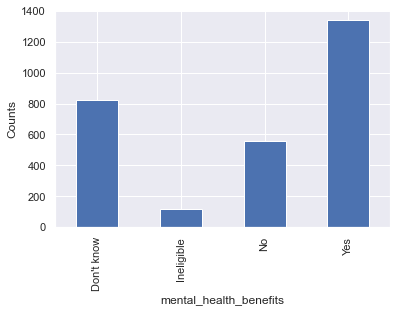

In [110]:
# Plot a bargraph for the counts (responses)

fig = plt.figure()
ax3 = fig.add_subplot(111)

benefits.plot(kind="bar")

ax3.set_ylabel('Counts')

### Visualizing the column ''Does your employer provide mental health benefits as part of healthcare coverage?'' & 'Do you currently have a mental health disorder?'

In [111]:
df13_filtered2 = df13_filtered[df13_filtered['mental_health_disorder'].notnull()]
df13_filtered2['mental_health_benefits'] 

1260    Ineligible
1261            No
1262            No
1265           Yes
1266    Don't know
           ...    
4391           Yes
4392    Don't know
4394           Yes
4395    Don't know
4397    Ineligible
Name: mental_health_benefits, Length: 1954, dtype: object

In [112]:
# Group by 'Does your employer provide mental health benefits as part of healthcare coverage?' 
# and 'Do you currently have a mental health disorder?' and count the number of responses 

benefits_trend = df13_filtered2.groupby(['mental_health_benefits', 'mental_health_disorder'])['mental_health_disorder'].count()
benefits_trend

mental_health_benefits  mental_health_disorder
Don't know              Don't Know                105
                        No                        220
                        Yes                       199
Ineligible              Don't Know                 20
                        No                         37
                        Yes                        57
No                      Don't Know                 51
                        No                        131
                        Yes                       140
Yes                     Don't Know                107
                        No                        277
                        Yes                       610
Name: mental_health_disorder, dtype: int64

In [113]:
# Normalize the counts into percentages for each year and convert it into a dataframe

df_filtered_benefits = df13_filtered2.groupby(['mental_health_benefits'])['mental_health_disorder'].value_counts(normalize=True).mul(100).rename('Percent (Normalized)').reset_index()
df_filtered_benefits

,mental_health_benefits,mental_health_disorder,Percent (Normalized)
0,Don't know,No,41.984733
1,Don't know,Yes,37.977099
2,Don't know,Don't Know,20.038168
3,Ineligible,Yes,50.000000
4,Ineligible,No,32.456140
5,Ineligible,Don't Know,17.543860
6,No,Yes,43.478261
7,No,No,40.683230
8,No,Don't Know,15.838509
9,Yes,Yes,61.368209


In [114]:
# Subset only those who gave a definite answer of either "Yes" or "No" to the questions
# 'Does your employer provide mental health benefits as part of healthcare coverage?'
# &  'Do you currently have a mental health disorder?'
# for graph plotting

df_filtered_benefits2 = df_filtered_benefits[df_filtered_benefits['mental_health_disorder'].isin(['Yes', 'No'])]
df_filtered_benefits2 = df_filtered_benefits2[df_filtered_benefits2['mental_health_benefits'].isin(['Yes', 'No'])]
df_filtered_benefits2

,mental_health_benefits,mental_health_disorder,Percent (Normalized)
6,No,Yes,43.478261
7,No,No,40.683230
9,Yes,Yes,61.368209
10,Yes,No,27.867203


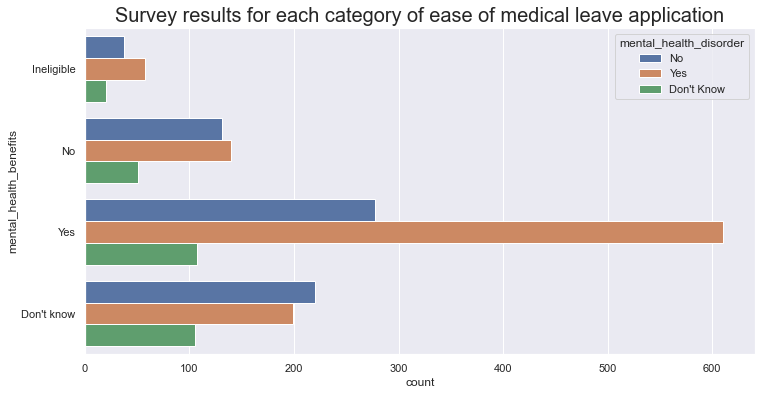

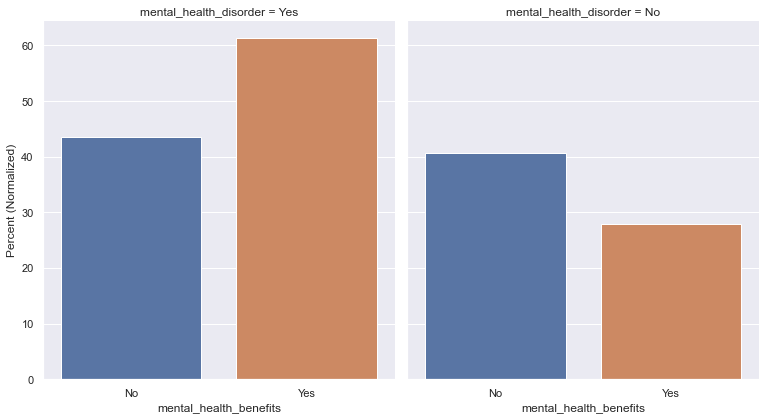

In [115]:
# Plotting graphs for visualization

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.set(font_scale = 1)
ax1 = sns.countplot(y='mental_health_benefits', hue='mental_health_disorder', data=df13_filtered2)
ax1.set_title('Survey results for each category of ease of medical leave application', fontsize = 20)

g = sns.catplot(data=df_filtered_benefits2, x='mental_health_benefits', y="Percent (Normalized)", col='mental_health_disorder',
            kind="bar", height=6, aspect=.9)

plt.tight_layout()
g.tight_layout()

### Insights: Respondents with mental health illness are aware of the availability of medical health care benefits in the company (note increased trend in 'Do you currently have a mental health disorder?' = 'Yes'). </br> Therefore, awareness of mental health benefits is a feature that could help support a person at risk of mental health issue in IT industry.

## Q10) Are respondents with mental health issues aware of whether their employer provide healthcare coverage?  - based on the hypothesis that knowing availability of mental healthcare coverage plays a role in mental health issues in IT industry (association score = 0.16 from heatmap & Chi-square test statistics of 34.89) 

### Visualizing the column 'Do you know the options for mental health care available under your employer-provided coverage?' 

In [116]:
# filter out all the null values in the column 'Do you know the options for mental health care available under your employer-provided coverage?'
# subset only the data corresponding to tech company/organization (== 'Yes') and self_employed (== 'No')

df14_filtered = df[df['mental_health_coverage'].notnull()]
df14_filtered = df14_filtered[df14_filtered['tech_company']=='Yes']
df14_filtered = df14_filtered[df14_filtered['selfemployed']=='No']
df14_filtered['mental_health_coverage'] 

20           Yes
22           Yes
24      Not sure
26      Not sure
27           Yes
          ...   
4389         Yes
4391         Yes
4392          No
4394         Yes
4395          No
Name: mental_health_coverage, Length: 2611, dtype: object

In [117]:
# Group by 'Do you know the options for mental health care available under your employer-provided coverage?' 
# and count the number of responses

coverage = df14_filtered.groupby(['mental_health_coverage'])['mental_health_coverage'].count()
coverage

mental_health_coverage
No          1148
Not sure     494
Yes          969
Name: mental_health_coverage, dtype: int64

Text(0, 0.5, 'Counts')

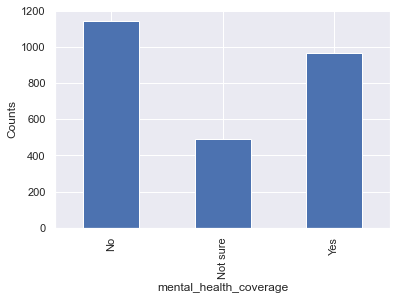

In [118]:
# Plot a bargraph for the counts (responses)

fig = plt.figure()
ax3 = fig.add_subplot(111)

coverage.plot(kind="bar")

ax3.set_ylabel('Counts')

### Visualizing the column ''Do you know the options for mental health care available under your employer-provided coverage?'' & 'Do you currently have a mental health disorder?'

In [119]:
df14_filtered2 = df14_filtered[df14_filtered['mental_health_disorder'].notnull()]
df14_filtered2['mental_health_coverage'] 

1261         Yes
1265    Not sure
1266          No
1267         Yes
1270    Not sure
          ...   
4389         Yes
4391         Yes
4392          No
4394         Yes
4395          No
Name: mental_health_coverage, Length: 1728, dtype: object

In [120]:
# Group by 'Do you know the options for mental health care available under your employer-provided coverage?' 
# and 'Do you currently have a mental health disorder?' and count the number of responses 

coverage_trend = df14_filtered2.groupby(['mental_health_coverage', 'mental_health_disorder'])['mental_health_disorder'].count()
coverage_trend

mental_health_coverage  mental_health_disorder
No                      Don't Know                125
                        No                        322
                        Yes                       340
Not sure                Don't Know                 62
                        No                        105
                        Yes                       100
Yes                     Don't Know                 64
                        No                        151
                        Yes                       459
Name: mental_health_disorder, dtype: int64

In [121]:
# Normalize the counts into percentages for each year and convert it into a dataframe

df_filtered_coverage = df14_filtered2.groupby(['mental_health_coverage'])['mental_health_disorder'].value_counts(normalize=True).mul(100).rename('Percent (Normalized)').reset_index()
df_filtered_coverage

,mental_health_coverage,mental_health_disorder,Percent (Normalized)
0,No,Yes,43.202033
1,No,No,40.914867
2,No,Don't Know,15.883100
3,Not sure,No,39.325843
4,Not sure,Yes,37.453184
5,Not sure,Don't Know,23.220974
6,Yes,Yes,68.100890
7,Yes,No,22.403561
8,Yes,Don't Know,9.495549


In [122]:
# Subset only those who gave a definite answer of either "Yes" or "No" to the questions
# 'Do you know the options for mental health care available under your employer-provided coverage?'
# &  'Do you currently have a mental health disorder?'
# for graph plotting

df_filtered_coverage2 = df_filtered_coverage[df_filtered_coverage['mental_health_disorder'].isin(['Yes', 'No'])]
df_filtered_coverage2 = df_filtered_coverage2[df_filtered_coverage2['mental_health_coverage'].isin(['Yes', 'No'])]
df_filtered_coverage2

,mental_health_coverage,mental_health_disorder,Percent (Normalized)
0,No,Yes,43.202033
1,No,No,40.914867
6,Yes,Yes,68.100890
7,Yes,No,22.403561


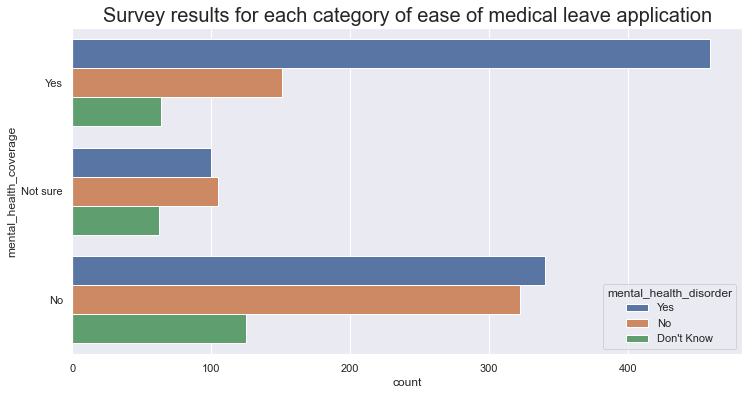

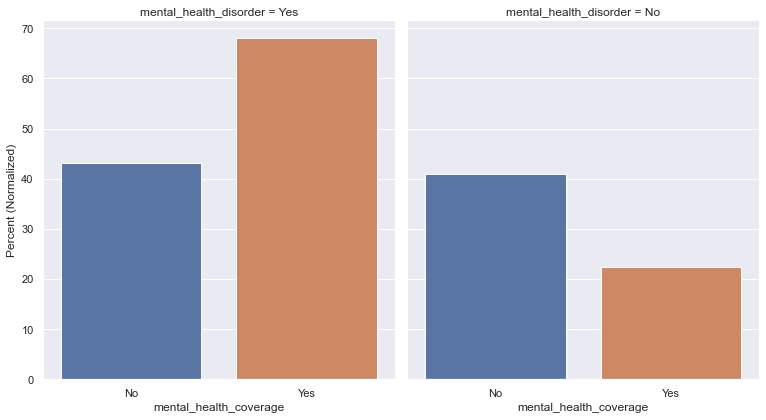

In [123]:
# Plotting graphs for visualization

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sns.set(font_scale = 1)
ax1 = sns.countplot(y='mental_health_coverage', hue='mental_health_disorder', data=df14_filtered2)
ax1.set_title('Survey results for each category of ease of medical leave application', fontsize = 20)

g = sns.catplot(data=df_filtered_coverage2, x='mental_health_coverage', y="Percent (Normalized)", col='mental_health_disorder',
            kind="bar", height=6, aspect=.9)

plt.tight_layout()
g.tight_layout()

### Insights: Respondents with mental health illness are aware of the medical health care coverage in the company (note increased trend in 'Do you currently have a mental health disorder?' = 'Yes'). </br> Therefore, awareness of mental health coverage is a feature that could help support a person at risk of mental health issue in IT industry.

## Predictive Models (Logistic Regression or RandomForest) for classification of mental health illness 

### Select those feature columns useful for modelling and encode them into values "0", "1", "2" or "3"

In [124]:
# select those features/categorical columns for modelling

data_filtered2 = data_filtered[['gender', 'family_history', 'treatment', 'num_of_employees', 'medical_leave', 'mental_health_benefits', 'mental_health_coverage', 'mental_health_disorder']]
data_filtered2

,gender,family_history,treatment,num_of_employees,medical_leave,mental_health_benefits,mental_health_coverage,mental_health_disorder
2693,female,No,Yes,M,Don't know,No,Yes,Yes
2694,male,No,No,M,Don't know,Yes,Yes,Yes
2695,male,Yes,Yes,S,Difficult,Don't know,No,Yes
2696,male,I don't know,Yes,L,Difficult,Yes,Yes,Yes
2698,male,Yes,No,M,Easy,Yes,No,No
...,...,...,...,...,...,...,...,...
4392,male,No,No,L,Easy,Don't know,No,No
4393,male,No,No,L,Difficult,No,No,No
4394,female,No,No,S,Easy,Yes,Yes,Yes
4395,male,Yes,Yes,M,Easy,Don't know,No,Yes


In [125]:
def encoding(string):
    """returns the encoded value"""
    if string == 'female':  
        return '0' 
    elif string == 'male':  
        return '1'     
    elif string == 'others': 
        return "2"
    elif string == 'No':  
        return '0'    
    elif string == 'Yes':  
        return '1'  
    elif string == "I don't know":  
        return '2'    
    elif string == 'S':  
        return '0'
    elif string == 'M':  
        return '1'
    elif string == 'L':  
        return '2'  
    elif string == 'Easy':  
        return '0'
    elif string == 'Difficult':  
        return '1'
    elif string == "Don't know":  
        return '2'      
    elif string == "Ineligible":  
        return '3'    
    else:
        return string

In [126]:
data_filtered3 = data_filtered2.applymap(encoding)
data_filtered3 = data_filtered3.astype(int)
data_filtered3

,gender,family_history,treatment,num_of_employees,medical_leave,mental_health_benefits,mental_health_coverage,mental_health_disorder
2693,0,0,1,1,2,0,1,1
2694,1,0,0,1,2,1,1,1
2695,1,1,1,0,1,2,0,1
2696,1,2,1,2,1,1,1,1
2698,1,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...
4392,1,0,0,2,0,2,0,0
4393,1,0,0,2,1,0,0,0
4394,0,0,0,0,0,1,1,1
4395,1,1,1,1,0,2,0,1


In [127]:
# check for any null values that will affect the modelling performance

data_filtered3.isnull().sum()

gender                    0
family_history            0
treatment                 0
num_of_employees          0
medical_leave             0
mental_health_benefits    0
mental_health_coverage    0
mental_health_disorder    0
dtype: int64

### Create the following numpy arrays named X and y respectively:
- X: stores the values of all the independent variables in dataframe
- y: stores the values of the dependent variable in dataframe

In [128]:
dfX = data_filtered3[['gender', 'family_history', 'treatment', 'num_of_employees', 'medical_leave', 'mental_health_benefits', 'mental_health_coverage']] # Features (independent or input variables)
dfy = data_filtered3['mental_health_disorder'] # Target variable (dependent or output variables)

In [129]:
# Convert the Pandas Dataframe to NumPY Array for modelling purpose
X = dfX.values
y = dfy.values

### Using the X and y numpy arrays, split the sample dataset into 75% training data and 25% testing data.

In [130]:
# Use a test size of 0.25

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state=2)

In [131]:
# use the x and y train for fitting into model
print(X_train.shape) # 902 rows for 7 columns
print(y_train.shape) # 902 rows

# use X_test to generate a set of predictions
print(X_test.shape) # use this to generate a set of predictions (301 rows for 7 columns)

# compare the predictions with the actual labels
print(y_test.shape) # use these predictions and compare it to y_test to assess the model performance

(902, 7)
(902,)
(301, 7)
(301,)


### Build a logistic regression model, logreg, and train the model using the training dataset with the following model specifications:
- Random State = 36
- C = 1e8
- Solver = ‘lbfgs’
- Maximum Iterations = 10000

In [132]:
# Form the model
# The parameters given for forming the model are based off experience, and can be set as shown for initial runs and later fine tuned as required
logreg = LogisticRegression(random_state=36, C = 1.0, solver='lbfgs', max_iter=10000)

# Fit the model
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=36)

### Using the logreg model, predict the target values using testing data. 

In [133]:
# Run the prediction
logreg_pred = logreg.predict(X_test)

# Print the y_pred output
print(logreg_pred)

[1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 0 1 1 1
 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1
 0 0 1 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1
 1 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1
 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 0 1
 0 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 1 1 1 1]


### Calculate and print the testing accuracy, precision, recall scores and confusion matrix of the logreg model.

Accuracy: 0.80
Precision: 0.84
Recall: 0.88


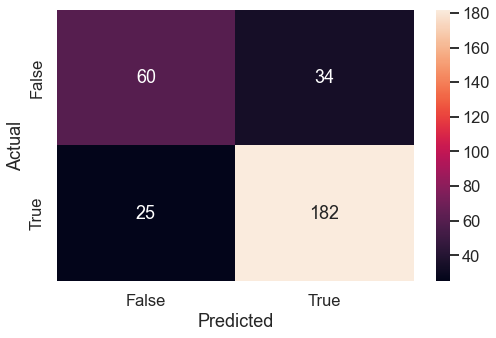

In [134]:
# The metrics allow the use of confusion matrix for y_test and y_pred
accuracy = metrics.accuracy_score(y_test, logreg_pred)
precision = metrics.precision_score(y_test, logreg_pred)
recall = metrics.recall_score(y_test, logreg_pred)

print("Accuracy: %.2f" % accuracy)
print("Precision: %.2f" % precision)
print("Recall: %.2f" % recall)

plt.figure(figsize=(8,5))

cnf_matrix_logreg = metrics.confusion_matrix(y_test, logreg_pred) # There are 182 TPs, 60 TNs, 34 FPs, 25 FNs

sns.set_context('talk')
ax = sns.heatmap(cnf_matrix_logreg, annot=True, fmt='d')
labels = ['False', 'True']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);
ax.set_ylabel('Actual');
ax.set_xlabel('Predicted');

In [135]:
logreg_clfRep = classification_report(y_test, logreg_pred)
print(logreg_clfRep)

              precision    recall  f1-score   support

           0       0.71      0.64      0.67        94
           1       0.84      0.88      0.86       207

    accuracy                           0.80       301
   macro avg       0.77      0.76      0.77       301
weighted avg       0.80      0.80      0.80       301



### Build a RandomForest model, forest, and train the model using the training dataset with the following model specifications:
- max_depth = 200
- max_features = 3
- min_samples_leaf = 5
- min_samples_split = 8
- n_estimators = 1000 
- ccp_alpha = 0.001 
- random_state= 36

In [136]:
# Form the model
forest = RandomForestClassifier(max_depth = 200, max_features = 3, 
                                min_samples_leaf = 5, min_samples_split = 8, 
                                n_estimators = 1000, ccp_alpha = 0.001, random_state= 36)
# Fit the model
forest.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.001, max_depth=200, max_features=3,
                       min_samples_leaf=5, min_samples_split=8,
                       n_estimators=1000, random_state=36)

### Using the RandomForest model, predict the target values using testing data. 

In [137]:
# Run the prediction
forest_pred = forest.predict(X_test)

# Print the y_pred output
print(forest_pred)

[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1
 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 0 0
 0 0 1 0 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0
 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1 0 1 1 0 1 1
 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1
 1 1 0 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1 0 1 0 1 0 1 1 1 1 1 0 1 0 0 1
 0 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1
 1 1 0 1 1]


### Calculate and print the testing accuracy, precision, recall scores and confusion matrix of the forest model.

Accuracy: 0.80
Precision: 0.85
Recall: 0.87


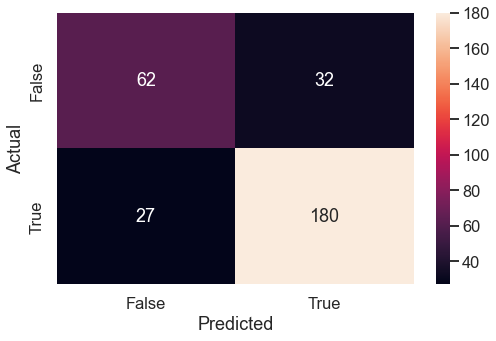

In [138]:
# The metrics allow the use of confusion matrix for y_test and forest_pred
accuracy = metrics.accuracy_score(y_test, forest_pred)
precision = metrics.precision_score(y_test, forest_pred)
recall = metrics.recall_score(y_test, forest_pred)

print("Accuracy: %.2f" % accuracy)
print("Precision: %.2f" % precision)
print("Recall: %.2f" % recall)

plt.figure(figsize=(8,5))

cnf_matrix_forest = metrics.confusion_matrix(y_test, forest_pred) # There are 180 TPs, 62 TNs, 32 FPs, 27 FNs

sns.set_context('talk')
ax = sns.heatmap(cnf_matrix_forest, annot=True, fmt='d')
labels = ['False', 'True']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);
ax.set_ylabel('Actual');
ax.set_xlabel('Predicted');

In [139]:
forest_clfRep = classification_report(y_test, forest_pred)
print(forest_clfRep)

              precision    recall  f1-score   support

           0       0.70      0.66      0.68        94
           1       0.85      0.87      0.86       207

    accuracy                           0.80       301
   macro avg       0.77      0.76      0.77       301
weighted avg       0.80      0.80      0.80       301



In [140]:
forest.feature_importances_

array([0.02787823, 0.25580656, 0.54597711, 0.04627809, 0.05487435,
       0.04117311, 0.02801255])

In [141]:
pd.DataFrame({'feature': dfX.columns,
             'importance': forest.feature_importances_})

,feature,importance
0,gender,0.027878
1,family_history,0.255807
2,treatment,0.545977
3,num_of_employees,0.046278
4,medical_leave,0.054874
5,mental_health_benefits,0.041173
6,mental_health_coverage,0.028013


In [142]:
# This implies that treatment, family_history are strong indicators of whether a responder is currently having mental health illness

feature_importance = pd.DataFrame({'feature': dfX.columns,
                                    'importance': forest.feature_importances_}).sort_values('importance', ascending = False).reset_index().drop(columns='index')
feature_importance.index = feature_importance.index + 1
feature_importance

,feature,importance
1,treatment,0.545977
2,family_history,0.255807
3,medical_leave,0.054874
4,num_of_employees,0.046278
5,mental_health_benefits,0.041173
6,mental_health_coverage,0.028013
7,gender,0.027878


### Insights: Both Logistic Regression and RandomForest models have similar performance in terms of metric scores such as accuracy (0.8), precision (0.84) and recall (0.88). Ranking of feature importance from RandomForest model implies that 'treatment' (0.54), 'family_history' (0.25) are strong indicators of whether a responder is currently having mental health illness or not. Therefore, these two features could strongly predict whether a person is at risk of mental health issue in IT industry.

## Data Visualization and Dissemination Framework

## 1. Characteristics of employees with mental health illness

### Demographics of affected employees

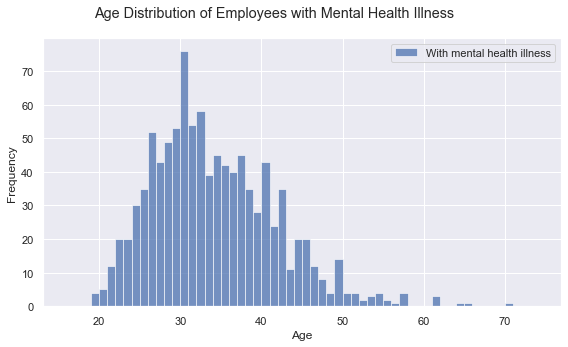

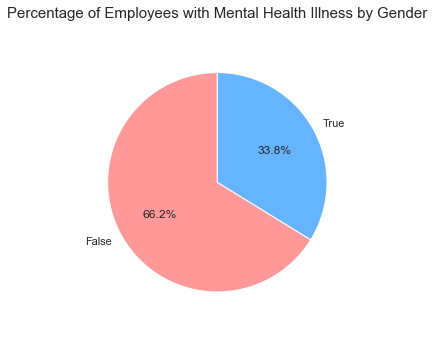

In [143]:
# Create a Dashboard of histogram/pie chart/spatial map

fig = plt.figure(figsize=(15,8), constrained_layout=True)
gs = GridSpec(nrows = 2,ncols= 2, figure = fig)
sns.set(font_scale = 1)

# 1st subplot: Geographical distribution of employees with mental health illness in US

iplot(choromap_states)
#plt.show()
#choromap_states.show(renderer="png")

#choromap_states.write_image(file='Geographical Distribution.png', format='png')

# 2nd subplot: Age distribution for employees with mental health illness

ax1 = plt.subplot(gs[0,0])
sns.histplot(with_mental_illness['age'], bins=range(16,75,1), alpha=0.75, label='With mental health illness')
ax1.set_xlabel('Age')
ax1.set_ylabel('Frequency')
ax1.legend()
fig.suptitle("Age Distribution of Employees with Mental Health Illness", x=0.25, y=1.05)

# 3rd subplot: Gender of employees with mental health illness

fig, ax2 = plt.subplots(figsize=(4, 5))
ax2.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Percentage of Employees with Mental Health Illness by Gender', fontsize = 15)
plt.tight_layout()
plt.show()


## 2. Association between different categorical variables

### Pairwise Association Plot and Chi-Square Test for Categorical variables

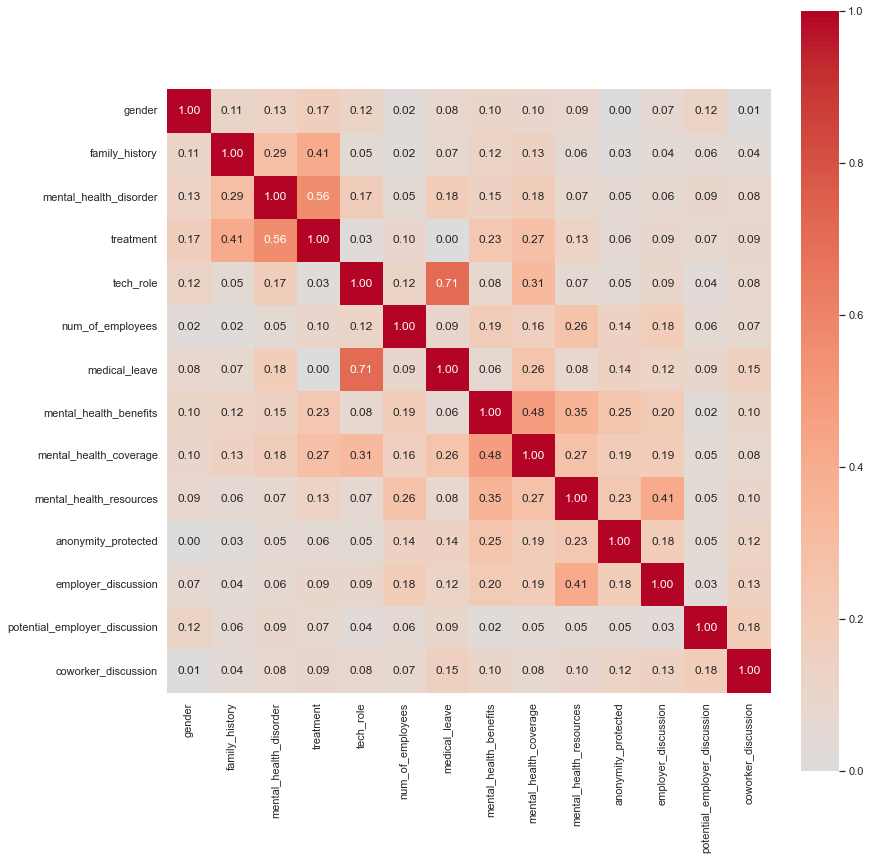

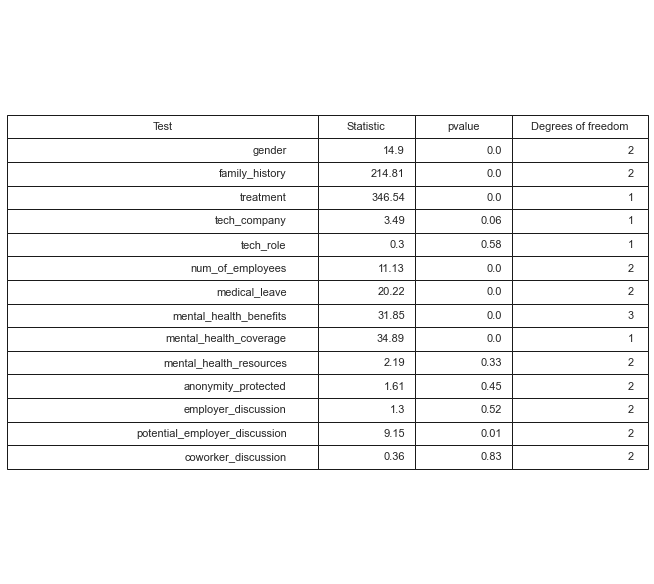

In [144]:
# Cramer's V association plot

# Instantiate a figure and axis object
fig, ax = plt.subplots(figsize = (12, 12), constrained_layout=True)

# Estimate and generate Cramer's V association plot
cramers_v = associations(df_filtered[df_list_new],
             nom_nom_assoc = 'cramer',
             ax = ax,
             cmap = "coolwarm")


# Subplot2: Chisquare's Test

fig, ax2 = plt.subplots(figsize = (8, 8), constrained_layout=True)
# hide axes
fig.patch.set_visible(False)
ax2.axis('off')
ax2.axis('tight')
# make table
table = plt.table(cellText=chisq_result.values,
                 #cellColours=[chisq_result.color],
                  colWidths=[.8,.25,.25,.35],
                  colLabels=chisq_result.columns,
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 1.5)
plt.show()

## 3. Predictive/Correlative Features suitable for Modelling

### Features that could predict or support employees at risk of mental health illness

Text(0.5, 0.6, 'Mental Health Coverage')

<Figure size 1080x1080 with 0 Axes>

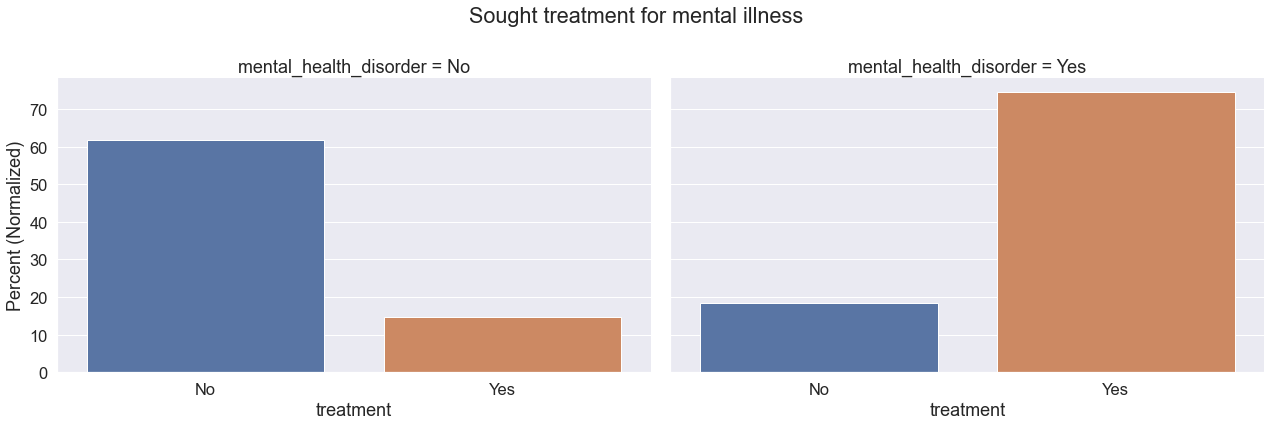

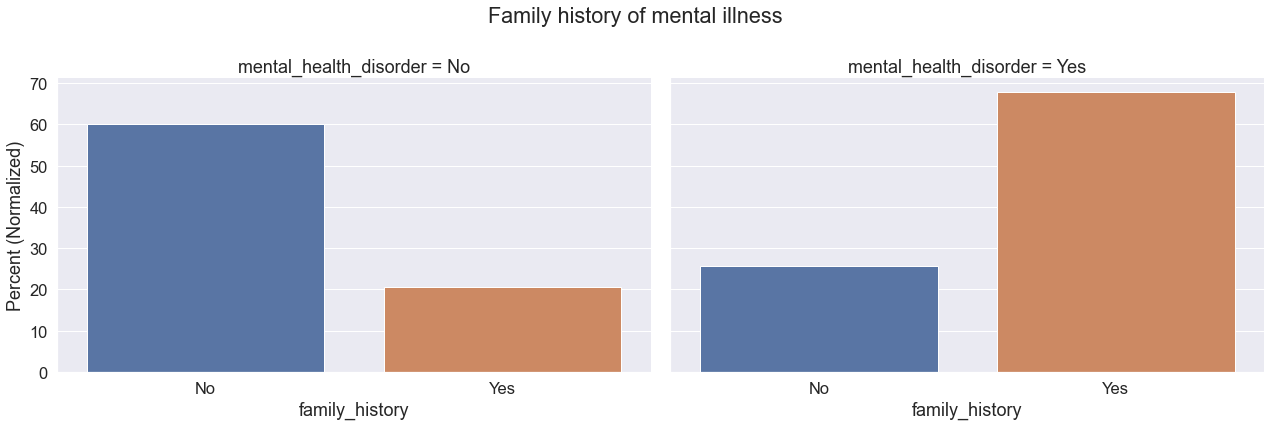

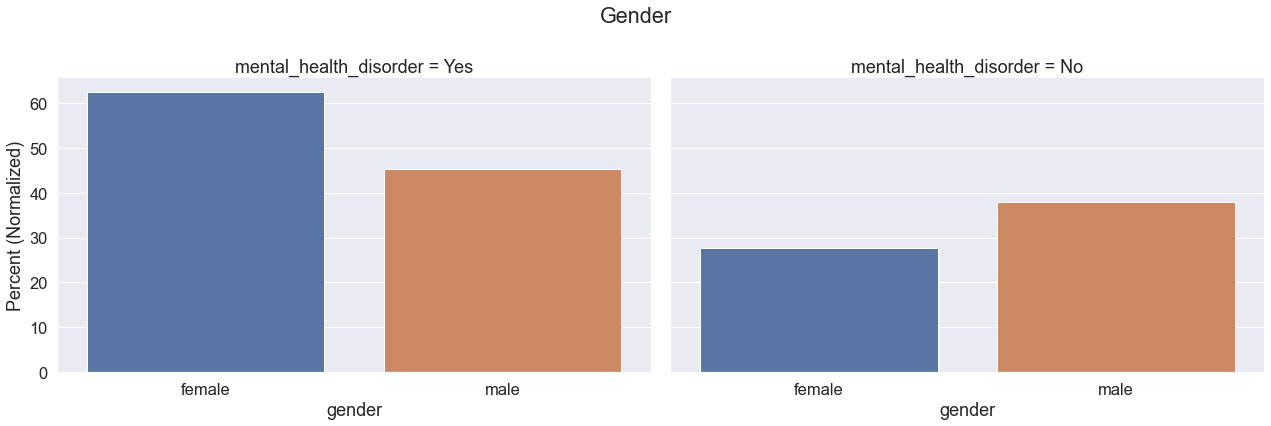

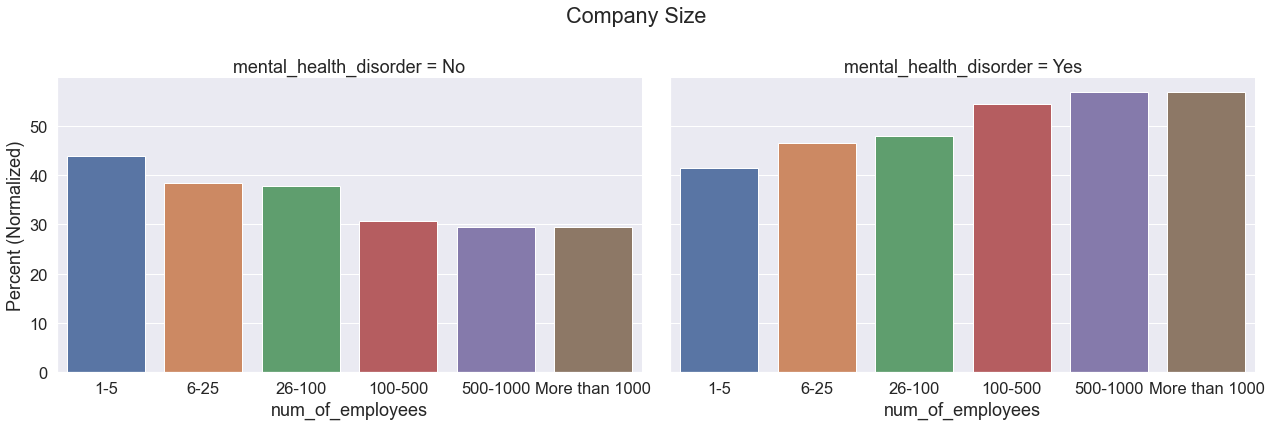

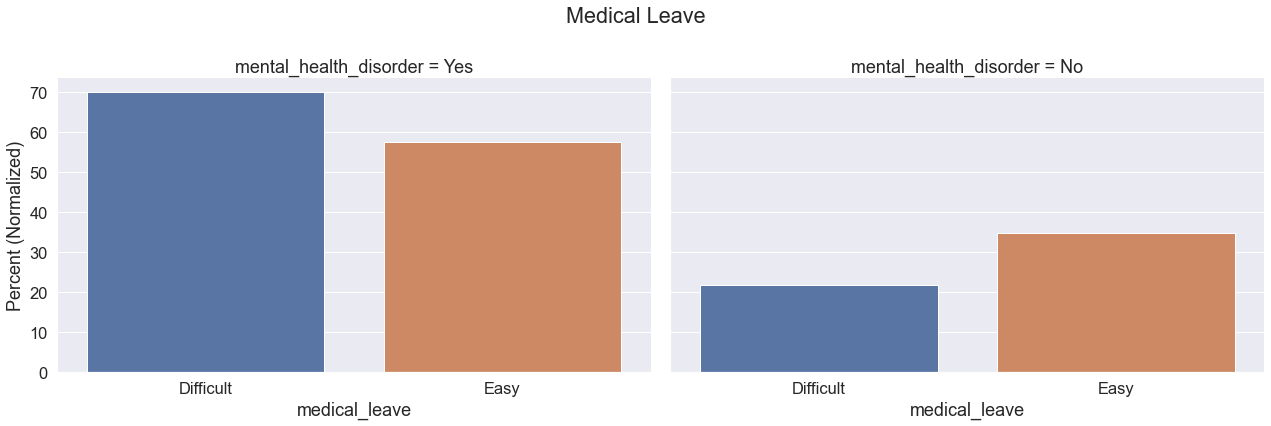

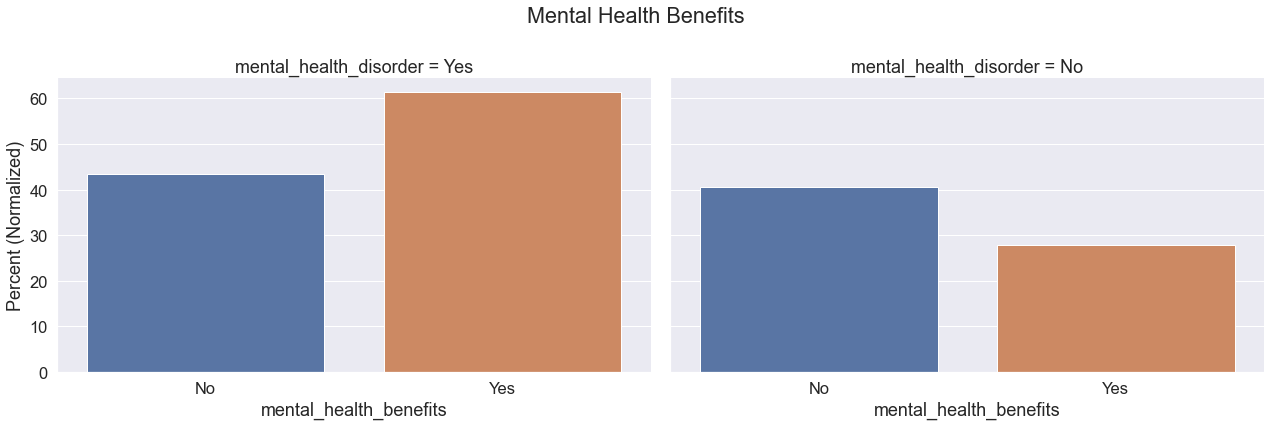

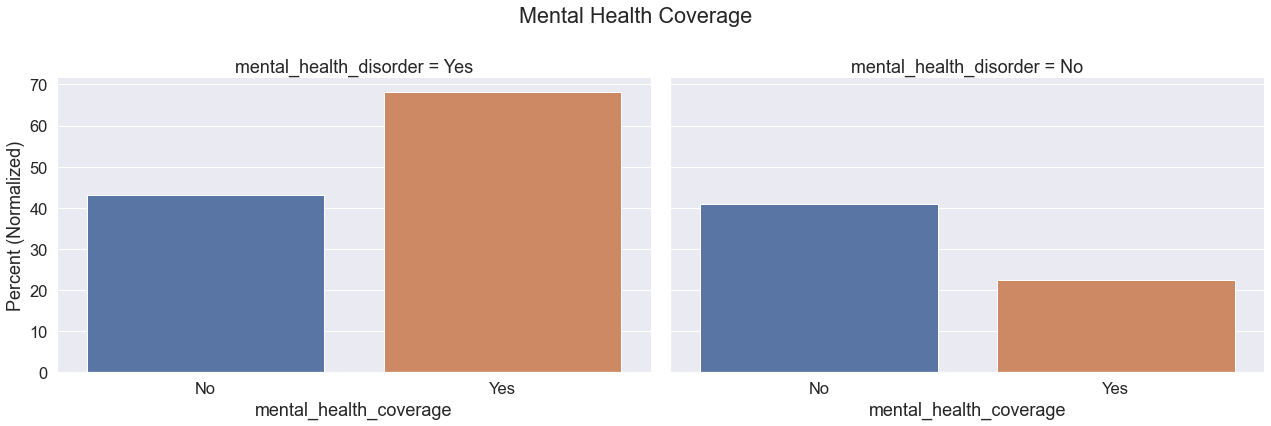

In [145]:
# Create a Dashboard of category plots

fig = plt.figure(figsize=(15,15), constrained_layout=True)
sns.set(font_scale = 1.5)

# 1st subplot: Sought treatment
ax1 = sns.catplot(data=df_filtered_treatment2, x='treatment', y="Percent (Normalized)", col='mental_health_disorder',
            kind="bar", height=10, aspect=.9)
ax1.fig.subplots_adjust(top=0.5) 
ax1.fig.suptitle("Sought treatment for mental illness", y=0.6)

# 2nd subplot: Family history of mental illness
ax2 = sns.catplot(data=df_filtered_family_history2, x='family_history', y="Percent (Normalized)", col='mental_health_disorder',
            kind="bar", height=10, aspect=.9)
ax2.fig.subplots_adjust(top=0.5) 
ax2.fig.suptitle("Family history of mental illness", y=0.6)

# 3rd subplot: Gender
ax3 = sns.catplot(data=df_filtered_gender2, x='gender', y="Percent (Normalized)", col='mental_health_disorder',
            kind="bar", height=10, aspect=.9)
ax3.fig.subplots_adjust(top=0.5) 
ax3.fig.suptitle("Gender", y=0.6)

# 4th subplot: Company Size
ax4 = sns.catplot(data=df_filtered_company_size2, x='num_of_employees', y="Percent (Normalized)", col='mental_health_disorder',
            kind="bar", height=10, aspect=.9, order=['1-5','6-25','26-100', '100-500', '500-1000', 'More than 1000'])
ax4.fig.subplots_adjust(top=0.5) 
ax4.fig.suptitle("Company Size", y=0.6)

# 5th subplot: Ease of Medical Leave Application
ax5 = sns.catplot(data=df_filtered_medical_leave2, x='medical_leave', y="Percent (Normalized)", col='mental_health_disorder',
            kind="bar", height=10, aspect=.9)
ax5.fig.subplots_adjust(top=0.5) 
ax5.fig.suptitle("Medical Leave", y=0.6)

# 6th subplot: Awareness of medical healthcare benefits
ax6 = sns.catplot(data=df_filtered_benefits2, x='mental_health_benefits', y="Percent (Normalized)", col='mental_health_disorder',
            kind="bar", height=10, aspect=.9)
ax6.fig.subplots_adjust(top=0.5) 
ax6.fig.suptitle("Mental Health Benefits", y=0.6)

# 7th subplot: Awareness of medical healthcare coverage
ax7 = sns.catplot(data=df_filtered_coverage2, x='mental_health_coverage', y="Percent (Normalized)", col='mental_health_disorder',
            kind="bar", height=10, aspect=.9)
ax7.fig.subplots_adjust(top=0.5) 
ax7.fig.suptitle("Mental Health Coverage", y=0.6)

## 4. Predictive Models for Classification of Mental Health Illness

### Performance of the predictive models (Logistic Regression & RandomForest)

Classification Report (Logistic Regression model)

              precision    recall  f1-score   support

           0       0.71      0.64      0.67        94
           1       0.84      0.88      0.86       207

    accuracy                           0.80       301
   macro avg       0.77      0.76      0.77       301
weighted avg       0.80      0.80      0.80       301


Classification Report (RandomForest model)

              precision    recall  f1-score   support

           0       0.70      0.66      0.68        94
           1       0.85      0.87      0.86       207

    accuracy                           0.80       301
   macro avg       0.77      0.76      0.77       301
weighted avg       0.80      0.80      0.80       301


Importance of features (RandomForest model)


,feature,importance
1,treatment,0.545977
2,family_history,0.255807
3,medical_leave,0.054874
4,num_of_employees,0.046278
5,mental_health_benefits,0.041173
6,mental_health_coverage,0.028013
7,gender,0.027878


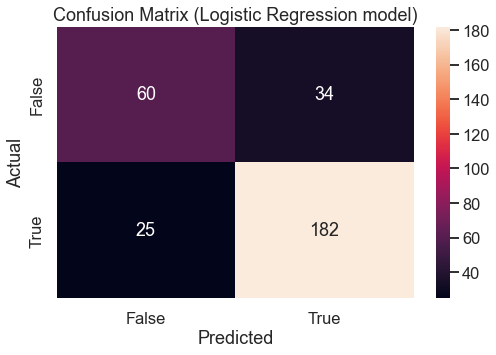

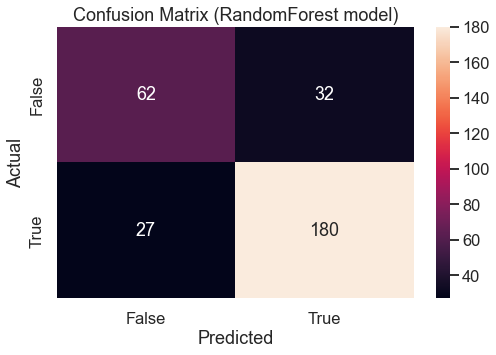

In [146]:
# Create a Dashboard of classification report and confusion matrix

print('Classification Report (Logistic Regression model)')
print()
print(logreg_clfRep)
print()

plt.figure(figsize=(8,5))

cnf_matrix_logreg = metrics.confusion_matrix(y_test, logreg_pred) \

sns.set_context('talk')
ax = sns.heatmap(cnf_matrix_logreg, annot=True, fmt='d')
labels = ['False', 'True']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);
ax.set_ylabel('Actual');
ax.set_xlabel('Predicted');
ax.set_title("Confusion Matrix (Logistic Regression model)")


print('Classification Report (RandomForest model)')
print()
print(forest_clfRep)
print()

plt.figure(figsize=(8,5))

cnf_matrix_forest = metrics.confusion_matrix(y_test, forest_pred) \

sns.set_context('talk')
ax = sns.heatmap(cnf_matrix_forest, annot=True, fmt='d')
labels = ['False', 'True']
ax.set_xticklabels(labels);
ax.set_yticklabels(labels);
ax.set_ylabel('Actual');
ax.set_xlabel('Predicted');
ax.set_title("Confusion Matrix (RandomForest model)")

print('Importance of features (RandomForest model)')
feature_importance

## End of Notebook